# M4 | Research Investigation Notebook

In this notebook, you will do a research investigation of your chosen dataset in teams. You will begin by formally selecting your research question (task 0), then processing your data (task 1), creating a predictive model (task 2), evaluating your model's results (task 3), and describing the contributions of each team member (task 4).

For grading, please make sure your notebook has all cells run and is stored in your team's [Github Classroom repository](https://classroom.github.com/a/CNxME27U). You will also need to write a short, 2 page report about your design decisions as a team, to be stored in your repository. The Milestone 4 submission will be the contents of your repository at the due date (April 28 at 23:59 CET).

## Brief overview of Calcularis
[Calcularis](https://school.alemira.com/de/calcularis/) by Alemira School is a mathematics learning program developed with neuroscientists and computer scientists from ETH Zurich. It promotes the development and interaction of the different areas of the brain that are responsible for processing numbers and quantities and solving mathematical tasks. Calcularis can be used from 1st grade to high school. Children with dyscalculia also benefit in the long term and overcome their arithmetic weakness.

The Calcularis dataset has three main tables:
* ***users***: meta information about users (i.e. total time spent learning with Calcularis, geographic location).
* ***events***: events done by the users in the platform (i.e. playing a game, selecting a new animal in the zoo simulation).
* ***subtasks***: sub-tasks with answer attempts solved by users, primarily in the context of game events.

These tables and useful metadata information are described in detail in the [Milestone 2 data exploration notebook](https://github.com/epfl-ml4ed/mlbd-2023/blob/main/project/milestone-02/m2_calcularis_sciper.ipynb).

We have provided access to the [full dataset](https://moodle.epfl.ch/mod/forum/discuss.php?d=88179) (~65k users) and a randomly selected subset (~1k users from M2). We have also provided access to a [test account to experiment with Calcularis](https://moodle.epfl.ch/mod/forum/discuss.php?d=88094). You should provide arguments and justifications for all of your design decisions throughout this investigation. You can use your M3 responses as the basis for this discussion.

In [1]:
import seaborn as sns 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import pprint
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression as lr
from sklearn import metrics
from scipy import stats
from pyBKT.models import Model
from sklearn import feature_extraction, model_selection

# Create pretty printer with indent of 4 and compact lists and also ndarrays

from pprint import PrettyPrinter
pp = PrettyPrinter(indent=4, compact=True)
np.set_printoptions(precision=3, suppress=True)


%matplotlib inline


In [95]:
# Import the tables of the data set as dataframes.
DATA_DIR = './data' # You many change the directory

# You can use the nrows=X argument in pd.read_csv to truncate your data
events = pd.read_csv(DATA_DIR+'/full_calcularis_events.csv'.format(DATA_DIR), index_col=0)
subtasks = pd.read_csv(DATA_DIR+'/full_calcularis_subtasks.csv'.format(DATA_DIR), index_col=0)
users = pd.read_csv(DATA_DIR+'/full_calcularis_users.csv'.format(DATA_DIR), index_col=0)

In [3]:
print(len(events))
print(len(subtasks))
print(len(users))

2185200
3502884
64932


## Task 0: Research Question

***Research questions:***  
**A- Do students who use free training versus those who don't perform worse or better?**    
**B- How can we predict user performance on a set of skills, including addition, multiplication, number line, etc.?**

## Task 1: Data Preprocessing



**Events processing**

In [8]:
events.isna().any()

user_id             False
mode                 True
game_name            True
learning_time_ms     True
subtasks             True
number_range         True
start               False
end                  True
skill_id             True
type                False
dtype: bool

In [9]:
#events are indexed on users and events id
events = events.reset_index().set_index(['event_id', 'user_id'])
#remove nan values
events = events.dropna()
len(events)

2153208

In [10]:
#we end up solely with games data
events.type.unique()

array(['task'], dtype=object)

In [11]:
import ast 
#process subtasks syntax
events.subtasks = events.subtasks.map(lambda x : ast.literal_eval(x))

In [12]:
#example of subtask entry
events.subtasks.iloc[0]

[{'hasProperResult': True,
  'range': 'R10',
  'correct': False,
  'answer': 4,
  'correctNumber': 1,
  'type': 'ConciseSubitizingTaskDescription',
  'subtask_finished_timestamp': '2020-08-20T07:14:29.954Z',
  'correctAnswerObject': 1},
 {'mode': 'STEPS',
  'correct': True,
  'range': 'R10',
  'timeoutInSteps': 2,
  'timeoutInSeconds': 0.0,
  'answer': 2,
  'type': 'ConciseTimeoutDescription',
  'correctAnswerObject': None,
  'subtask_finished_timestamp': '2020-08-20T07:14:29.954Z',
  'hasProperResult': True}]

The second subtask entry in the example has no correctAnswerObject, hence one can't assess how far the student was from the answer. We decide that a subtask is valid if hasProperResult is True (subtask is answerable) and all of correct, type, answer and correctAnswerObject fields are present and valid. Also we want to consider the range field to be able to assess the level of the asnwered subtask.

In [13]:
def check_subtask_entry(x,fields={'correct', 'correctAnswerObject', 'answer', 'range', 'type'}):
    #we want to assess user's performance, theses fields are necessary to do so
    return len(fields.intersection(x))==len(fields) and x['hasProperResult'] and all([not x[f] is None for f in fields])

In [14]:
events_pre = events.copy()
events_pre.subtasks.map(lambda x :sum([ 1 if check_subtask_entry(xi) else 0 for xi in x])).value_counts().sort_index()
#events can have multiple subtasks, we need to filter out non valid subtasks entries

0        28441
1      1977111
2        38416
3        35337
4         7168
        ...   
104          2
108          1
124          2
127          1
147          1
Name: subtasks, Length: 89, dtype: int64

In [15]:
events_pre.subtasks = events_pre.subtasks.map(lambda x : [xi for xi in x if check_subtask_entry(xi)])
#drop events that end up with 0 valid subtasks entries
events_pre = events_pre.drop(events_pre[events_pre['subtasks'].map(len)==0].index)
#check on previous example
events_pre.subtasks.iloc[0]
print('length of events df : {}'.format(len(events_pre)))

length of events df : 2124767


Now we compute the score for each user in each event

In [16]:
#Assign a weight to each game based on its difficulty level
complexity_dict = {'R10': 1, 'R20': 2, 'R100': 10, 'R1000': 100}
#add the scores earned depending complexity for each event
score=events_pre.subtasks.map(lambda x : [complexity_dict[xi['range']] if xi['correct'] else 0 for xi in x])
#add the types of subtask for each event
subtypes = events_pre.subtasks.map(lambda x : [xi['type'] for xi in x])
events_pre['score'] = score
events_pre['sub_types'] = subtypes
events_pre

,,mode,game_name,learning_time_ms,subtasks,number_range,start,end,skill_id,type,score,sub_types
event_id,user_id,,,,,,,,,,,
1,2,NORMAL,Subitizing,"13,094.00000","[{'hasProperResult': True, 'range': 'R10', 'co...",R10,2020-08-20T07:13:50.876Z,2020-08-20T07:14:30.108Z,1.00000,task,[0],[ConciseSubitizingTaskDescription]
3,2,NORMAL,Conversion,"15,879.00000","[{'answer': 6, 'range': 'R10', 'correct': True...",R10,2020-08-21T07:02:20.112Z,2020-08-21T07:02:36.221Z,3.00000,task,[1],[ConciseConversionTaskDescription]
4,2,NORMAL,Landing,"6,075.00000","[{'range': 'R10', 'correct': True, 'lowerBound...",R10,2020-08-24T07:02:59.855Z,2020-08-24T07:03:07.382Z,18.00000,task,[1],[ConciseLandingTaskDescription]
5,2,NORMAL,Landing,"6,910.00000","[{'range': 'R10', 'correct': True, 'lowerBound...",R10,2020-08-26T06:47:21.504Z,2020-08-26T06:47:30.050Z,19.00000,task,[1],[ConciseLandingTaskDescription]
6,2,NORMAL,Calculator,"7,507.00000","[{'range': 'R20', 'answerMode': 'RESULT', 'cor...",R20,2020-08-26T07:20:58.766Z,2020-08-26T07:21:06.439Z,54.00000,task,[2],[ConciseEquationTaskDescription]
...,...,...,...,...,...,...,...,...,...,...,...,...
2399317,64997,END_OF_NR,Landing,"6,075.00000","[{'aim': 83, 'startPosition': 0.5, 'lowerBound...",R1000,2020-03-24T09:12:33.561Z,2020-03-24T09:12:43.293Z,179.00000,task,[100],[ConciseLandingTaskDescription]
2399318,64997,END_OF_NR,Estimation,"2,621.00000","[{'numbers': [974, 532, 160], 'type': 'Concise...",R1000,2020-03-26T07:43:29.873Z,2020-03-26T07:43:33.289Z,167.00000,task,[100],[ConciseEstimationTaskDescription]
2399319,64997,END_OF_NR,Secret Number,"68,768.00000",[{'type': 'ConciseNumberInIntervalTaskDescript...,R1000,2020-03-28T08:33:44.445Z,2020-03-28T08:34:53.298Z,178.00000,task,"[100, 100, 100, 100, 100, 100]","[ConciseNumberInIntervalTaskDescription, Conci..."


To be able to grasp the skill the user is working in a given event, we want to map the skill id field to the domain it corresponds to

In [17]:
#Read and pretty print content of pickle file skill_sets_ids.pkl
with open('data/skill_sets_ids_merged.pkl', 'rb') as f:
    skill_sets_ids = pickle.load(f)

pprint.pprint(skill_sets_ids, compact=True)

{'Addition': [186, 184, 191, 21, 125, 213, 57, 63, 130, 216, 58, 212, 121, 205,
              123, 218, 26, 193, 119, 132, 185, 192, 204, 22, 194, 54, 201, 215,
              217, 195, 202, 23, 183, 59, 214, 116, 219, 53, 114, 203],
 'Division': [162, 242, 249, 156, 87, 85, 241, 88, 245, 158, 247, 157, 155, 90,
              246, 243, 248, 91, 83, 160, 240, 251, 163, 159, 244, 86, 84, 161,
              82, 89],
 'Multiplication': [148, 141, 149, 236, 140, 78, 76, 238, 73, 77, 144, 237, 153,
                    150, 75, 139, 143, 142, 152, 80, 235, 74, 154, 239, 147, 79,
                    146, 233, 151, 250, 232, 138, 234, 81, 145, 44, 100, 172],
 'Number_line': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                 18, 19, 20, 25, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
                 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 67, 68, 69, 70,
                 71, 72, 92, 93, 94, 95, 96, 97, 98, 99, 101, 102, 103, 104,
                 105, 106

In [18]:
#each event only reference to one skill
events_pre['skill']=events_pre.skill_id.map(lambda x : [skill for skill in skill_sets_ids if x in skill_sets_ids[skill]][0])
events_pre

,,mode,game_name,learning_time_ms,subtasks,number_range,start,end,skill_id,type,score,sub_types,skill
event_id,user_id,,,,,,,,,,,,
1,2,NORMAL,Subitizing,"13,094.00000","[{'hasProperResult': True, 'range': 'R10', 'co...",R10,2020-08-20T07:13:50.876Z,2020-08-20T07:14:30.108Z,1.00000,task,[0],[ConciseSubitizingTaskDescription],Number_line
3,2,NORMAL,Conversion,"15,879.00000","[{'answer': 6, 'range': 'R10', 'correct': True...",R10,2020-08-21T07:02:20.112Z,2020-08-21T07:02:36.221Z,3.00000,task,[1],[ConciseConversionTaskDescription],Number_line
4,2,NORMAL,Landing,"6,075.00000","[{'range': 'R10', 'correct': True, 'lowerBound...",R10,2020-08-24T07:02:59.855Z,2020-08-24T07:03:07.382Z,18.00000,task,[1],[ConciseLandingTaskDescription],Number_line
5,2,NORMAL,Landing,"6,910.00000","[{'range': 'R10', 'correct': True, 'lowerBound...",R10,2020-08-26T06:47:21.504Z,2020-08-26T06:47:30.050Z,19.00000,task,[1],[ConciseLandingTaskDescription],Number_line
6,2,NORMAL,Calculator,"7,507.00000","[{'range': 'R20', 'answerMode': 'RESULT', 'cor...",R20,2020-08-26T07:20:58.766Z,2020-08-26T07:21:06.439Z,54.00000,task,[2],[ConciseEquationTaskDescription],Addition
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2399317,64997,END_OF_NR,Landing,"6,075.00000","[{'aim': 83, 'startPosition': 0.5, 'lowerBound...",R1000,2020-03-24T09:12:33.561Z,2020-03-24T09:12:43.293Z,179.00000,task,[100],[ConciseLandingTaskDescription],Number_line
2399318,64997,END_OF_NR,Estimation,"2,621.00000","[{'numbers': [974, 532, 160], 'type': 'Concise...",R1000,2020-03-26T07:43:29.873Z,2020-03-26T07:43:33.289Z,167.00000,task,[100],[ConciseEstimationTaskDescription],Number_line
2399319,64997,END_OF_NR,Secret Number,"68,768.00000",[{'type': 'ConciseNumberInIntervalTaskDescript...,R1000,2020-03-28T08:33:44.445Z,2020-03-28T08:34:53.298Z,178.00000,task,"[100, 100, 100, 100, 100, 100]","[ConciseNumberInIntervalTaskDescription, Conci...",Number_line


We do not want users who did not perform enough events to bias our analysis

In [19]:
def filter_usage(events_pre,thresh=5) :
    #we perform a groupby on the user_id and then we perform count to see how many games were played by each usr
    df_count = events_pre.groupby(['user_id'])['game_name'].count().to_frame('num_games')
    #we filter out users that played less than thresh games
    list_to_remove = df_count[df_count['num_games'] < thresh].index.values
    filtered_events_pre = events_pre[~events_pre.index.get_level_values('user_id').isin(list_to_remove)]
    #we also want to remove users that are not registered in the users table
    filtered_events_pre = filtered_events_pre[filtered_events_pre.index.get_level_values('user_id').isin(users.dropna().index.values)]
    return filtered_events_pre

In [20]:
for thresh in [5,10,20,50,100] :
    filtered_events_pre = filter_usage(events_pre,thresh)
    print('Length of events with users playing more than {} games : {}'.format(thresh,len(filtered_events_pre)))
    filtered_events_pre.to_pickle('data/events_pre{}.pkl'.format(thresh))
    break
    

Length of events with users playing more than 5 games : 1500753


**Subtasks processing**

In [17]:
subtasks.columns

Index(['event_id', 'user_id', 'aim', 'answer', 'answerMode',
       'availableNumbers', 'correct', 'correctAnswerObject', 'correctNumber',
       'destination', 'distance', 'hasProperResult', 'interval', 'lowerBound',
       'maxHeight', 'minHeight', 'mode', 'multiplier', 'number',
       'numberRepresentations', 'numberToMultiply', 'numbers', 'operandA',
       'operandB', 'operator', 'range', 'representation', 'representations',
       'result', 'solution', 'solutionRepresentation', 'solveMode', 'source',
       'speed', 'startPosition', 'subtask_finished_timestamp', 'target',
       'timeoutInSeconds', 'timeoutInSteps', 'type', 'upperBound', 'step',
       'orderIndependent', 'divisor', 'larger', 'smaller', 'timeout'],
      dtype='object')

In [18]:
len(subtasks)

3502884

For now subtask table is exploded event table, we can add later features from subtask table if wanted

In [19]:
for thresh in [5,10,20,50,100] :
    with open('data/events_pre{}.pkl'.format(thresh), 'rb') as f:
        events_pre = pickle.load(f)
    subtasks_pre = events_pre.explode(['subtasks','sub_types','score']).reset_index()
    subtasks_pre.index=subtasks_pre.index.rename('subtask_id')
    subtasks_pre['correct']=subtasks_pre['subtasks'].map(lambda x : x['correct'])
    print('Length of subtasks with users playing more than {} games : {}'.format(thresh,len(subtasks_pre)))
    subtasks_pre.to_pickle('data/subtasks_pre{}.pkl'.format(thresh))
#example of subtask entry
subtasks_pre.head(1)

Length of subtasks with users playing more than 5 games : 1986197
Length of subtasks with users playing more than 10 games : 1949109
Length of subtasks with users playing more than 20 games : 1825873
Length of subtasks with users playing more than 50 games : 1329398
Length of subtasks with users playing more than 100 games : 681419


,event_id,user_id,mode,game_name,learning_time_ms,subtasks,number_range,start,end,skill_id,type,score,sub_types,skill,correct
subtask_id,,,,,,,,,,,,,,,
0,1,2,NORMAL,Subitizing,13094.0,"{'hasProperResult': True, 'range': 'R10', 'cor...",R10,2020-08-20T07:13:50.876Z,2020-08-20T07:14:30.108Z,1.0,task,0,ConciseSubitizingTaskDescription,Number_line,False


**Users processing**

In [20]:
print(users.index.is_unique)
print("We have {} distinct users".format(len(users.index)))

True
We have 64932 distinct users


In [21]:
users.isna().any()

learning_time_ms     False
logged_in_time_ms    False
language              True
country               True
start                False
end                  False
dtype: bool

In [22]:
users=users.dropna()
print("We now have {} users".format(len(users.index)))

We now have 48778 users


In [9]:
def report_scores(events_pre,subtasks_pre,index,scaled=False) :
    '''This function returns the scores earned by each user in each skill and each range'''
    score_metric = 'scaled_score_score' if scaled else 'score'
    #sum up earned scores in each skill and each range
    res=subtasks_pre.groupby(['user_id', 'skill','number_range'])['score'].sum().to_frame()
    #we devide by the maximum possible to earn score
    div=subtasks_pre.groupby(['user_id', 'skill','number_range'])['score'].count().to_frame()
    div=div.apply(lambda x : x*complexity_dict[x.name[2]],axis=1)
    w_score=res*100/div
    #min max scaling to scores
    w_score['scaled_score'] = (w_score['score'] - w_score['score'].min()) / (w_score['score'].max() - w_score['score'].min())
    #now we want to report all earned scores in a dictionnary for each user
    skills=events_pre.skill.unique() 
    scores= pd.DataFrame(index = index,columns=np.append(skills,'max_level_solved'))
    empty_scores = {c:0 for c in complexity_dict}
    empty_levels = {s:'R10' for s in skills}
    scores[skills]=scores[skills].apply(lambda x : [empty_scores.copy() for i in range(len(skills))],axis=1,result_type='expand')
    scores['max_level_solved']=scores['max_level_solved'].map(lambda x : empty_levels.copy())
    #get max level solved for each category
    highest=subtasks_pre[subtasks_pre.correct].groupby(['user_id','skill']).number_range.agg(lambda x : max(x,key=lambda s : int(s.split('R')[1]))).rename('max_level_attempted')
    #report max level
    for k,v in highest.to_dict().items() : 
        scores.loc[k[0]]['max_level_solved'][k[1]]=v
    #report scores
    for k,v in w_score.to_dict(orient='index').items():
        scores.loc[k[0]][k[1]][k[2]]=v[score_metric]
    return scores

In [10]:
def process_users(users,events_pre,subtasks_pre) :
    '''This function takes as input the target users, events_pre and subtasks_pre dataframes 
    returns users table with features of our interest'''
    #learning_time of each user
    learning_time = users.learning_time_ms
    #locality of each user
    ui_locale=users.country.rename("ui_locale")
    #events per user, we only have games in our events
    num_games=events_pre.reset_index().groupby('user_id').user_id.count().rename("number_of_games")
    #number of answers per users
    total_answers=subtasks_pre.groupby('user_id').user_id.count().rename("number_of_games")
    #computing the absolute percentage of correct answers per user
    abs_perc_correct=subtasks_pre.groupby('user_id').correct.apply(lambda x : (x==True).sum())
    abs_perc_correct= (abs_perc_correct*100/total_answers).rename("absolute_percentage_correct")
    #compute weighted scores and max level solved for each skill 
    w_score=report_scores(events_pre,subtasks_pre,ui_locale.index)
    #compute free training usage
    free_tr=events_pre[events_pre['mode']=='FREE_TRAINING'].groupby('user_id').learning_time_ms.agg(sum).rename('total_free_training_time_ms')
    users_pre=pd.concat([ui_locale,num_games,learning_time,abs_perc_correct,free_tr,w_score],axis=1).fillna(0)
    return users_pre

These defined function will allow us to form a final user table (for each chosen threshhold) that hold all needed features for each user

In [11]:
thresh = 5
with open('data/events_pre{}.pkl'.format(thresh), 'rb') as f:
    events_pre = pickle.load(f)
with open('data/subtasks_pre{}.pkl'.format(thresh), 'rb') as f:
    subtasks_pre = pickle.load(f)
#we are only interested on users that actually performed enough events wrt to our threshhold
filtered_users=users[users.index.isin(events_pre.index.get_level_values('user_id'))]
#we can process form our final user table
users_pre=process_users(filtered_users,events_pre,subtasks_pre)
for thresh in [5,10,20,50,100] :
    filtered_users_pre = users_pre[users_pre.number_of_games>thresh]
    print("Length of table for users who played more than {} games : {}".format(thresh,len(filtered_users_pre.index)))
    filtered_users_pre.to_pickle('data/users_pre{}.pkl'.format(thresh))

Length of table for users who played more than 5 games : 33876
Length of table for users who played more than 10 games : 29099
Length of table for users who played more than 20 games : 21710
Length of table for users who played more than 50 games : 9834
Length of table for users who played more than 100 games : 3147


In [76]:
#example of user_pre entries
users_pre.head()

,ui_locale,number_of_games,learning_time_ms,absolute_percentage_correct,total_free_training_time_ms,Number_line,Addition,Subtraction,Division,Multiplication,max_level_solved,Number_line_level,Addition_level,Subtraction_level,Division_level,Multiplication_level
user_id,,,,,,,,,,,,,,,,
2,NL,258,188171589,82.30958,"458,409.00000","{'R10': 86.20689655172414, 'R20': 100.0, 'R100...","{'R10': 0, 'R20': 100.0, 'R100': 0.0, 'R1000': 0}","{'R10': 0, 'R20': 0, 'R100': 100.0, 'R1000': 5...","{'R10': 0, 'R20': 40.0, 'R100': 100.0, 'R1000'...","{'R10': 0, 'R20': 0, 'R100': 100.0, 'R1000': 9...","{'Number_line': 'R1000', 'Addition': 'R20', 'S...",100,2,100,100,100
4,CH,77,73967025,75.72816,0.00000,"{'R10': 62.5, 'R20': 80.0, 'R100': 76.92307692...","{'R10': 0, 'R20': 0, 'R100': 0, 'R1000': 0}","{'R10': 0, 'R20': 33.333333333333336, 'R100': ...","{'R10': 0, 'R20': 0, 'R100': 0, 'R1000': 0}","{'R10': 0, 'R20': 100.0, 'R100': 0, 'R1000': 0}","{'Number_line': 'R100', 'Addition': 'R10', 'Su...",10,1,2,1,2
5,CH,41,41135378,82.35294,"49,893.00000","{'R10': 66.66666666666667, 'R20': 100.0, 'R100...","{'R10': 100.0, 'R20': 100.0, 'R100': 0, 'R1000...","{'R10': 0, 'R20': 0, 'R100': 100.0, 'R1000': 1...","{'R10': 0, 'R20': 0, 'R100': 0, 'R1000': 0}","{'R10': 0, 'R20': 0, 'R100': 100.0, 'R1000': 0}","{'Number_line': 'R1000', 'Addition': 'R20', 'S...",100,2,100,1,10
6,CH,37,37110540,94.87179,0.00000,"{'R10': 75.0, 'R20': 88.88888888888889, 'R100'...","{'R10': 0, 'R20': 0, 'R100': 0, 'R1000': 0}","{'R10': 0, 'R20': 0, 'R100': 0.0, 'R1000': 0}","{'R10': 0, 'R20': 100.0, 'R100': 0, 'R1000': 0}","{'R10': 0, 'R20': 100.0, 'R100': 0, 'R1000': 0}","{'Number_line': 'R100', 'Addition': 'R10', 'Su...",10,1,1,2,2
10,NL,19,24439636,47.36842,0.00000,"{'R10': 16.666666666666668, 'R20': 61.53846153...","{'R10': 0, 'R20': 0, 'R100': 0, 'R1000': 0}","{'R10': 0, 'R20': 0, 'R100': 0, 'R1000': 0}","{'R10': 0, 'R20': 0, 'R100': 0, 'R1000': 0}","{'R10': 0, 'R20': 0, 'R100': 0, 'R1000': 0}","{'Number_line': 'R20', 'Addition': 'R10', 'Sub...",2,1,1,1,1


In [80]:
with open('data/users_pre10.pkl', 'rb') as f:
    users_pre = pickle.load(f)
users_pre.head()

,ui_locale,number_of_games,learning_time_ms,absolute_percentage_correct,total_free_training_time_ms,Number_line,Addition,Subtraction,Division,Multiplication,max_level_solved,Number_line_level,Addition_level,Subtraction_level,Division_level,Multiplication_level
user_id,,,,,,,,,,,,,,,,
2,NL,258,188171589,82.30958,"458,409.00000","{'R10': 86.20689655172414, 'R20': 100.0, 'R100...","{'R10': 0, 'R20': 100.0, 'R100': 0.0, 'R1000': 0}","{'R10': 0, 'R20': 0, 'R100': 100.0, 'R1000': 5...","{'R10': 0, 'R20': 40.0, 'R100': 100.0, 'R1000'...","{'R10': 0, 'R20': 0, 'R100': 100.0, 'R1000': 9...","{'Number_line': 'R1000', 'Addition': 'R20', 'S...",100,2,100,100,100
4,CH,77,73967025,75.72816,0.00000,"{'R10': 62.5, 'R20': 80.0, 'R100': 76.92307692...","{'R10': 0, 'R20': 0, 'R100': 0, 'R1000': 0}","{'R10': 0, 'R20': 33.333333333333336, 'R100': ...","{'R10': 0, 'R20': 0, 'R100': 0, 'R1000': 0}","{'R10': 0, 'R20': 100.0, 'R100': 0, 'R1000': 0}","{'Number_line': 'R100', 'Addition': 'R10', 'Su...",10,1,2,1,2
5,CH,41,41135378,82.35294,"49,893.00000","{'R10': 66.66666666666667, 'R20': 100.0, 'R100...","{'R10': 100.0, 'R20': 100.0, 'R100': 0, 'R1000...","{'R10': 0, 'R20': 0, 'R100': 100.0, 'R1000': 1...","{'R10': 0, 'R20': 0, 'R100': 0, 'R1000': 0}","{'R10': 0, 'R20': 0, 'R100': 100.0, 'R1000': 0}","{'Number_line': 'R1000', 'Addition': 'R20', 'S...",100,2,100,1,10
6,CH,37,37110540,94.87179,0.00000,"{'R10': 75.0, 'R20': 88.88888888888889, 'R100'...","{'R10': 0, 'R20': 0, 'R100': 0, 'R1000': 0}","{'R10': 0, 'R20': 0, 'R100': 0.0, 'R1000': 0}","{'R10': 0, 'R20': 100.0, 'R100': 0, 'R1000': 0}","{'R10': 0, 'R20': 100.0, 'R100': 0, 'R1000': 0}","{'Number_line': 'R100', 'Addition': 'R10', 'Su...",10,1,1,2,2
10,NL,19,24439636,47.36842,0.00000,"{'R10': 16.666666666666668, 'R20': 61.53846153...","{'R10': 0, 'R20': 0, 'R100': 0, 'R1000': 0}","{'R10': 0, 'R20': 0, 'R100': 0, 'R1000': 0}","{'R10': 0, 'R20': 0, 'R100': 0, 'R1000': 0}","{'R10': 0, 'R20': 0, 'R100': 0, 'R1000': 0}","{'Number_line': 'R20', 'Addition': 'R10', 'Sub...",2,1,1,1,1


**We want to provide a visualization for a user's current level and strengths as a chart**

In [77]:
def visualize_radio_chart(df, student_id):
    interm = df.loc[student_id] 
    categories = ['{} {}'.format(m,n) for m,n in zip(interm.max_level_solved.keys(),interm.max_level_solved.values())] 
    student_scores = [interm[c][v] for c,v in zip(interm.max_level_solved.keys(),interm.max_level_solved.values())]
    student_scores += [student_scores[0]]

    fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=dict(polar=True))
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_rlabel_position(0)
    plt.xticks(np.linspace(0, 2*np.pi, len(categories) + 1)[:-1], categories)

    plt.plot(np.linspace(0, 2*np.pi, len(categories) + 1), student_scores)
    plt.fill(np.linspace(0, 2*np.pi, len(categories) + 1), student_scores, alpha=0.2)
    
    plt.title("user {} performance chart".format(student_id))
    plt.tight_layout()
    plt.show()

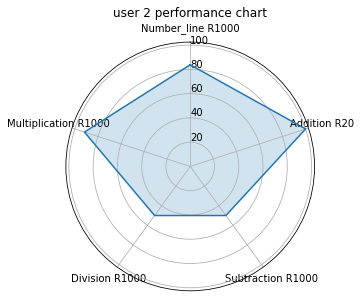

In [78]:
visualize_radio_chart(users_pre, 2)

## Task 2: Model Building

Train a model for your research question. 

**First research question : Do students who use free training peform better or worse than those who don't**

In [277]:
import pickle
with open('data/users_pre5.pkl', 'rb') as f:
    users_pre = pickle.load(f)
skills= ['Number_line', 'Addition', 'Subtraction', 'Division', 'Multiplication']
complexity_dict = {'R10': 1, 'R20': 2, 'R100': 10, 'R1000': 100}
#Here we encode max_level_solved for each skil to be able to use this feature for propensity score computing
for s in skills :
    users_pre[s+'_level']=users_pre.max_level_solved.map(lambda x : complexity_dict[x[s]])
users_pre.head(2)

,ui_locale,number_of_games,learning_time_ms,absolute_percentage_correct,total_free_training_time_ms,Number_line,Addition,Subtraction,Division,Multiplication,max_level_solved,Number_line_level,Addition_level,Subtraction_level,Division_level,Multiplication_level
user_id,,,,,,,,,,,,,,,,
2,NL,258,188171589,82.30958,"458,409.00000","{'R10': 86.20689655172414, 'R20': 100.0, 'R100...","{'R10': 0, 'R20': 100.0, 'R100': 0.0, 'R1000': 0}","{'R10': 0, 'R20': 0, 'R100': 100.0, 'R1000': 5...","{'R10': 0, 'R20': 40.0, 'R100': 100.0, 'R1000'...","{'R10': 0, 'R20': 0, 'R100': 100.0, 'R1000': 9...","{'Number_line': 'R1000', 'Addition': 'R20', 'S...",100,2,100,100,100
4,CH,77,73967025,75.72816,0.00000,"{'R10': 62.5, 'R20': 80.0, 'R100': 76.92307692...","{'R10': 0, 'R20': 0, 'R100': 0, 'R1000': 0}","{'R10': 0, 'R20': 33.333333333333336, 'R100': ...","{'R10': 0, 'R20': 0, 'R100': 0, 'R1000': 0}","{'R10': 0, 'R20': 100.0, 'R100': 0, 'R1000': 0}","{'Number_line': 'R100', 'Addition': 'R10', 'Su...",10,1,2,1,2


In [278]:
df=users_pre.copy()
df['total_free_training_time_ms'][df['total_free_training_time_ms']>0].describe()

count       7,160.00000
mean      170,189.54330
std       334,141.73729
min           361.00000
25%        14,901.75000
50%        62,299.00000
75%       179,992.00000
max     8,173,412.00000
Name: total_free_training_time_ms, dtype: float64

The mininimum for people who use free training is not that far from the mean. Hence we do not need to threshhold it

In [279]:
#compute binary treatement with no threshhold
df['total_free_training_time_ms']=df['total_free_training_time_ms'].apply(lambda x : 1 if x>0 else 0).rename('use_free_training')
#this featur will be our treatement through out the observational study
treatment='use_free_training'
df=df.rename({'total_free_training_time_ms': treatment},axis='columns')
y = df[treatment]
#get all features but treatement, as well as the performance scores of users
X = df[['ui_locale','number_of_games' , 'learning_time_ms']]
print(X)
#one hot encode the categorical locality feature
X_encoded = pd.get_dummies(X, columns = ['ui_locale'], drop_first=False)


        ui_locale  number_of_games  learning_time_ms
user_id                                             
2              NL              258         188171589
4              CH               77          73967025
5              CH               41          41135378
6              CH               37          37110540
10             NL               19          24439636
...           ...              ...               ...
64989          CH               12           9373016
64990          NL               40          21189696
64992          CH               48          59851157
64993          CH               76          83198994
64996          NL                6           6553507

[33876 rows x 3 columns]


In [280]:
def logit(p):
    logit_value = np.log(p / (1-p))
    return logit_value

In [281]:
#scale the features and perform logisitic regression
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic_classifier', lr())
])
pipe.fit(X_encoded, y)
predictions = pipe.predict_proba(X_encoded)
predictions_binary = pipe.predict(X_encoded)
#we use logit since the treatement here is binary defined
predictions_logit = np.array([logit(xi) for xi in predictions[:,1]])
print('Accuracy: {:.4f}\n'.format(metrics.accuracy_score(y, predictions_binary)))

Accuracy: 0.7940



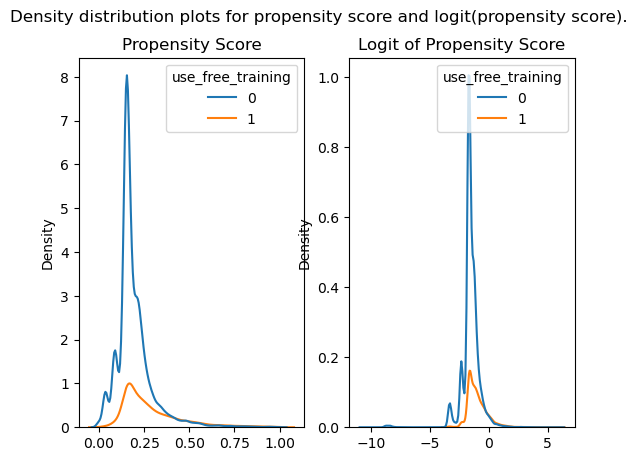

In [282]:
fig, ax = plt.subplots(1,2)
fig.suptitle('Density distribution plots for propensity score and logit(propensity score).')
sns.kdeplot(x = predictions[:,1], hue =y , ax = ax[0])
ax[0].set_title('Propensity Score')
sns.kdeplot(x = predictions_logit, hue =y , ax = ax[1])
ax[1].set_title('Logit of Propensity Score')
plt.show()

Looking at the logit density distribution, we have fare more treated than untreated users

In [283]:
#report back propensity scores to our df
X_encoded['propensity_score'] = predictions[:,1]
X_encoded['propensity_score_logit'] = predictions_logit
#report back scores data to our df
X_encoded[skills] = df[skills]
X_encoded['max_level_solved'] = df['max_level_solved']
X_encoded['absolute_percentage_correct'] = df['absolute_percentage_correct']
X_encoded[treatment] = df[treatment]

In [284]:
#our threshhold value, we choose to use 25% of standard deviation of propensity_score
caliper = np.std(X_encoded.propensity_score) * 0.25

print('Caliper value is: {}'.format(caliper))

#reset user_ids values to be able to perform knn
df_data = X_encoded.copy().reset_index()
#use knn to identify matching candidates
knn = NearestNeighbors(n_neighbors=10 , p = 2, radius=caliper)
knn.fit(df_data[['propensity_score_logit']].to_numpy())

Caliper value is: 0.03098295231421085


NearestNeighbors(n_neighbors=10, radius=0.03098295231421085)

In [285]:
# we obtain at most 10 nearest matches for each user, regardless they are treated or not
distances , indexes = knn.kneighbors(df_data[['propensity_score_logit']].to_numpy(), n_neighbors=10)
print('For item 0, the 4 closest distances are (first item is self):')
for ds,idx in zip(distances[0,0:4],indexes[0,0:4]):
    print('Element distance: {}, element index : {}'.format(ds,idx))

For item 0, the 4 closest distances are (first item is self):
Element distance: 0.0, element index : 0
Element distance: 0.001200659696004358, element index : 7627
Element distance: 0.0037907210233851796, element index : 31053
Element distance: 0.006259631667600241, element index : 11624


In [286]:
def perfom_matching(row, indexes, df_data):
    s=set()
    current_index = int(row.name) 
    #first element in indexes tab is the element itself, do not consider it
    for idx in indexes[current_index,1:]:
        #the elements can be treated or not, need to check the treatement state
        if ((row[treatment] == 1) and (df_data.loc[idx][treatment] == 0) and (idx not in s)):
            s.add(idx)
            return int(idx)

In [287]:
#get the matching for each treated user,
df_data['matched_element'] = df_data.apply(perfom_matching, axis = 1, args = (indexes, df_data))
#untreated users have nan values in their field, can drop them
free_tr=df_data.copy().dropna()
no_free_tr=df_data.loc[free_tr.matched_element]
#form our matched data
matched_data=pd.concat([free_tr,no_free_tr]).reset_index(drop=True)
print('Looks in order')
matched_data[treatment].value_counts()

Looks in order


1    7109
0    7109
Name: use_free_training, dtype: int64

**Analyzing the Free training effect on scores**

In [288]:
def quantiles(df,feature):
    return df.groupby(treatment)[feature].apply(np.quantile,q=[0.25,0.5,0.75])

def mean_std(df,feature):
    return df.groupby(treatment)[feature].agg([np.mean,np.std])

Absolute percentage score

In [289]:
print(quantiles(matched_data,'absolute_percentage_correct'))
mean_std(matched_data,'absolute_percentage_correct')

use_free_training
0    [69.23076923076923, 77.61194029850746, 83.7837...
1    [70.58823529411765, 78.18181818181819, 84.7682...
Name: absolute_percentage_correct, dtype: object


,mean,std
use_free_training,,
0,75.05166,12.73247
1,76.57231,11.67685


T-value: 0.02, p-value: 0.9833


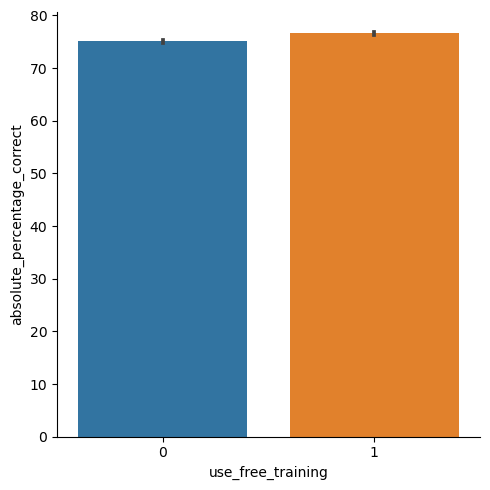

In [291]:
a=matched_data[['absolute_percentage_correct',treatment]]
sns.catplot(data=a, kind="bar", x=treatment, y='absolute_percentage_correct')
#conduct a t-test on means of different groups
t, p = stats.ttest_ind(a[a[treatment]==1].mean(), a[a[treatment]==0].mean())
print("T-value: {:.2f}, p-value: {:.4f}".format(t, p))

Skills scores

In [92]:
def report_skill_scores(skill) :
    a=matched_data[[skill,'max_level_solved']].apply(lambda x : x[skill][x.max_level_solved[skill]],axis=1).to_frame(name=skill)
    a[treatment]=matched_data[treatment]
    return a

def analyze_skill_score(skill) :
    skill_scores = report_skill_scores(skill)
    print('For skill {} : '.format(skill))
    print(quantiles(skill_scores,skill))
    print(mean_std(skill_scores,skill))
    #barplot the means
    sns.catplot(data=skill_scores, kind="bar", x=treatment, y=skill)

Addition

For skill Addition : 
use_free_training
0    [0.0, 20.0, 100.0]
1    [0.0, 50.0, 100.0]
Name: Addition, dtype: object
                        mean        std
use_free_training                      
0                  44.079908  46.386948
1                  46.776593  46.427074


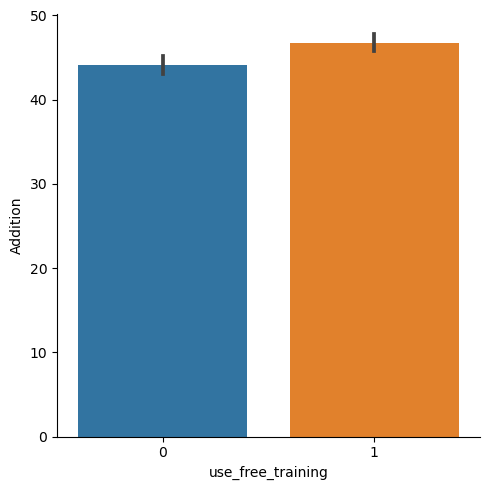

In [96]:
analyze_skill_score('Addition')

Substraction

For skill Subtraction : 
use_free_training
0    [0.0, 33.333333333333336, 100.0]
1                  [0.0, 50.0, 100.0]
Name: Subtraction, dtype: object
                        mean        std
use_free_training                      
0                  42.990454  45.069397
1                  46.600137  44.450703


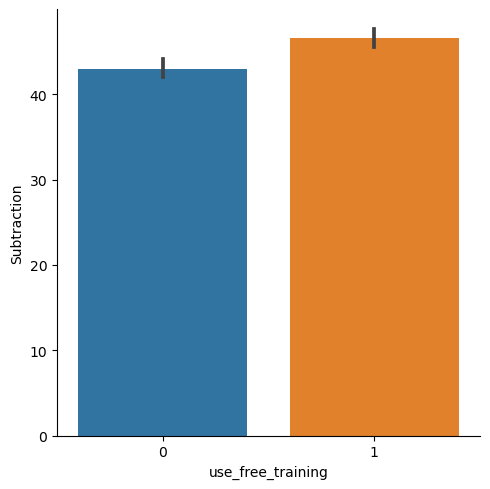

In [97]:
analyze_skill_score('Subtraction')

Division

For skill Division : 
use_free_training
0    [0.0, 0.0, 0.0]
1    [0.0, 0.0, 0.0]
Name: Division, dtype: object
                        mean        std
use_free_training                      
0                  15.209020  33.004276
1                  16.874812  34.142794


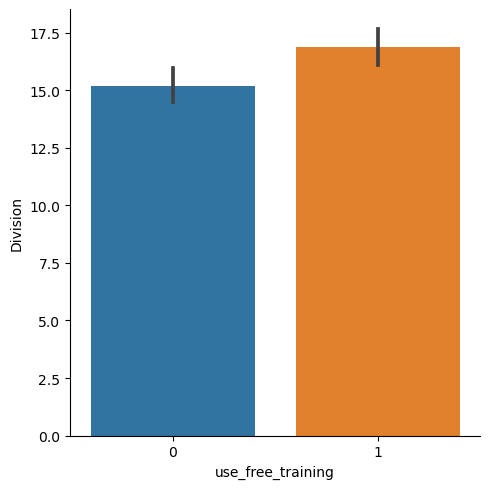

In [98]:
analyze_skill_score('Division')


Multiplication

For skill Multiplication : 
use_free_training
0    [0.0, 100.0, 100.0]
1    [0.0, 100.0, 100.0]
Name: Multiplication, dtype: object
                        mean        std
use_free_training                      
0                  59.421331  47.589069
1                  65.106425  45.625318


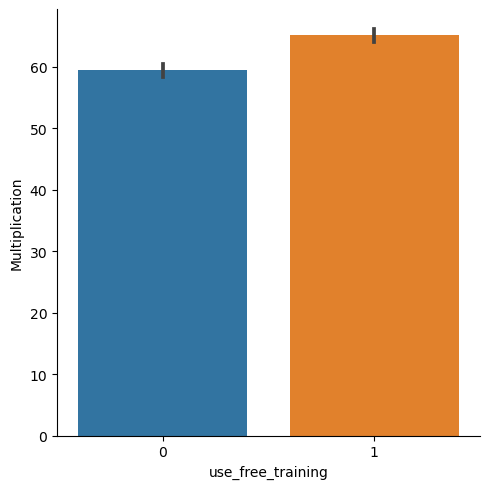

In [99]:
analyze_skill_score('Multiplication')

Number_line

For skill Number_line : 
use_free_training
0         [64.28571428571429, 77.77777777777777, 87.5]
1    [63.1578947368421, 77.58620689655173, 86.95652...
Name: Number_line, dtype: object
                        mean        std
use_free_training                      
0                  74.518989  17.839912
1                  73.632197  18.462328


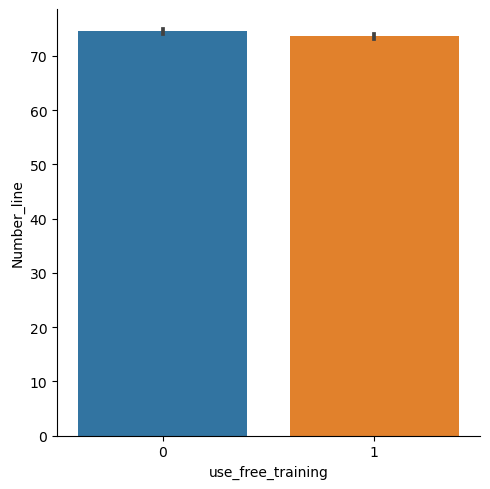

In [100]:
analyze_skill_score('Number_line')

Our results support that free_training users seem to perform better


## Task 3: Model Evaluation
In this task, you will use metrics to evaluate your model.

**Observational study evaluation**


Evaluate matching densities on the differente features

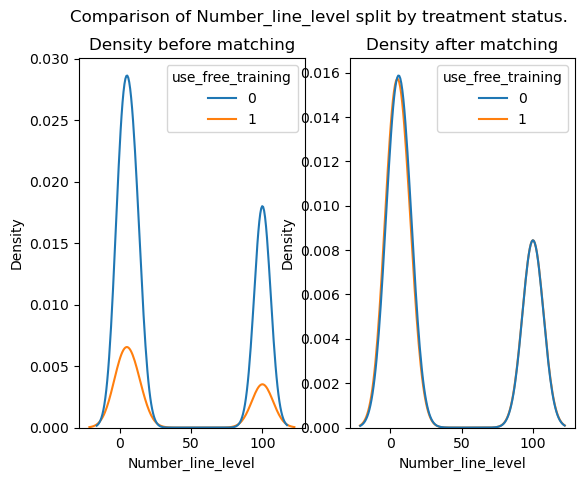

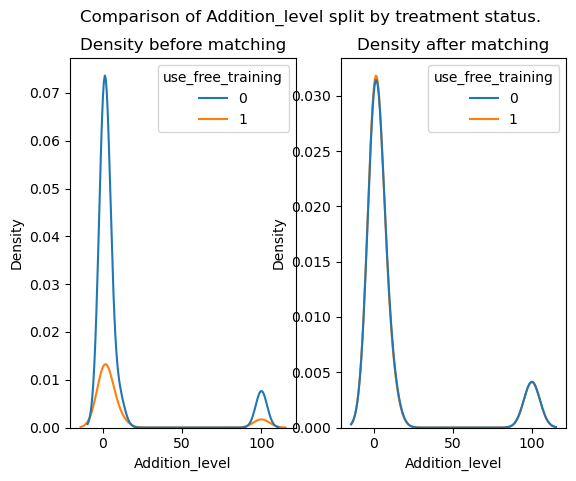

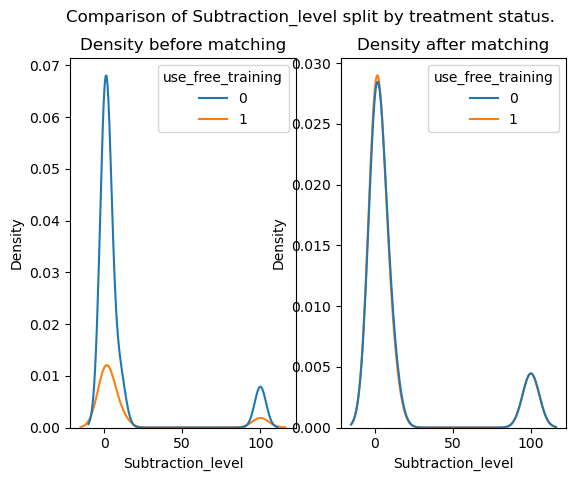

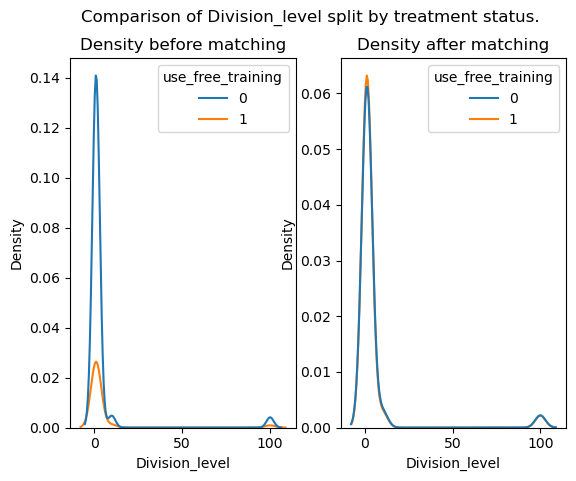

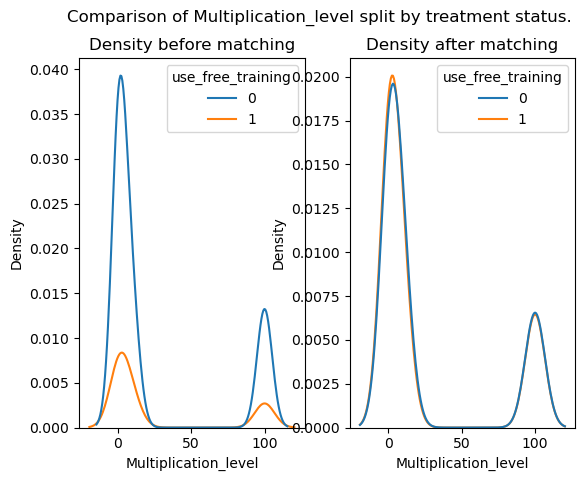

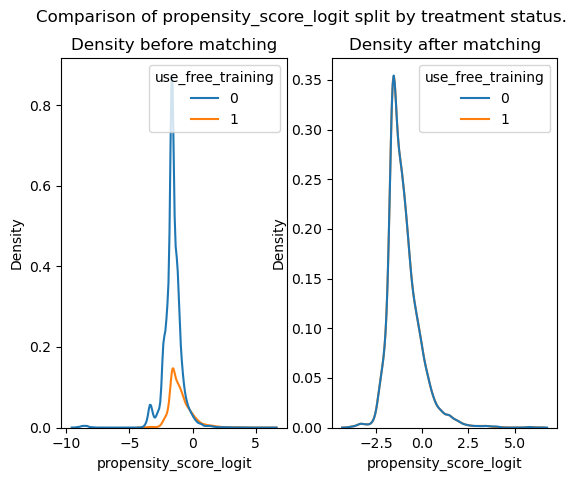

In [103]:
features=[s+'_level' for s in skills] + ['propensity_score_logit']

def plot(f):
    fig, ax = plt.subplots(1,2)
    fig.suptitle('Comparison of {} split by treatment status.'.format(f))
    sns.kdeplot(data = df_data, x = f, hue = treatment, ax = ax[0]).set(title='Density before matching')
    sns.kdeplot(data = matched_data, x = f, hue = treatment,  ax = ax[1]).set(title='Density after matching')
    plt.show()

for f in features:
    plot(f)

The densities after the matching look comparable

Now we will try to grasp the effect of the covariates on the population using the Cohen's D function.   
Cohen's d is a measure of the standardized difference between two means, and it's commonly used to estimate the effect size observational studies.

In [203]:
from statistics import mean, stdev

def cohenD (x, y):
    return (mean(x) - mean(y)) / (np.sqrt((stdev(x) ** 2 + stdev(y) ** 2) / 2))

C:\Users\Aouame\AppData\Local\Temp\ipykernel_19908\3637350176.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data.append([cl,'after', cohenD(matched_data[df_data[treatment]==1][cl],matched_data[df_data[treatment]==0][cl])])
C:\Users\Aouame\AppData\Local\Temp\ipykernel_19908\1165035941.py:4: RuntimeWarning: invalid value encountered in double_scalars
  return (mean(x) - mean(y)) / (np.sqrt((stdev(x) ** 2 + stdev(y) ** 2) / 2))
C:\Users\Aouame\AppData\Local\Temp\ipykernel_19908\1165035941.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  return (mean(x) - mean(y)) / (np.sqrt((stdev(x) ** 2 + stdev(y) ** 2) / 2))


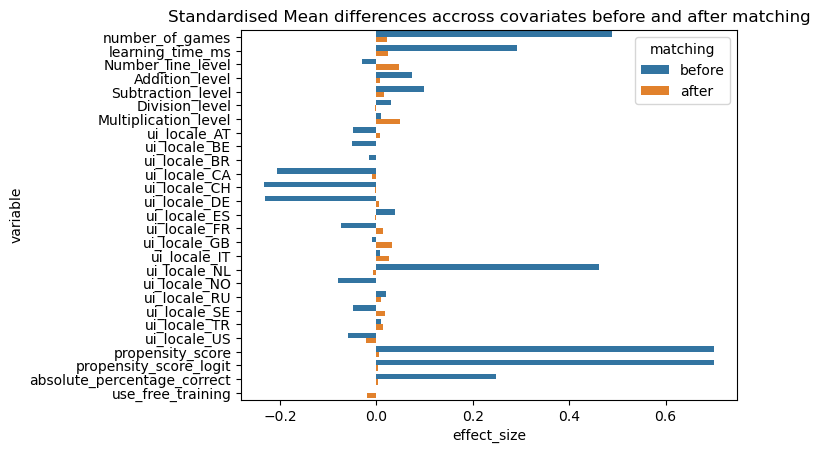

In [210]:
data = []
cols = matched_data.columns.drop(['user_id','Number_line', 'Addition', 'Subtraction', 'Division', 'Multiplication','max_level_solved','matched_element'])

for cl in cols:
    data.append([cl,'before', cohenD(df_data[df_data[treatment]==1][cl],df_data[df_data[treatment]==0][cl])])
    data.append([cl,'after', cohenD(matched_data[df_data[treatment]==1][cl],matched_data[df_data[treatment]==0][cl])])

res = pd.DataFrame(data, columns=['variable','matching','effect_size'])
sn_plot = sns.barplot(data = res, y = 'variable', x = 'effect_size', hue = 'matching', orient='h')
sn_plot.set(title='Standardised Mean differences accross covariates before and after matching')
sn_plot.figure.savefig("standardised_mean_differences.png")

## Task 2: Model Building

In the following section we train a BKT model, to predict user performence gieven a specific skill of a subtask.
The training was done for each clustered skill (Addition, Multiplication, ...) and on each numnber range difficulty, the models are all multi-learning (users) on clustered skill tasks.

There was a total of 4 * 5 - 1 = 29 models trained, (-1) accounting for no Division R10 skills.


In [2]:
# Read data from pkl file
df_subtasks = pd.read_pickle('data/subtasks_pre5.pkl')
# Create mapping column for skill 
col_names = { "skill" : "skill_name"}
df_subtasks.skill_id = df_subtasks.skill_id.astype(int)
df_subtasks.correct = df_subtasks.correct.astype(int)
df_subtasks.rename(columns=col_names, inplace=True)
df_subtasks.reset_index(inplace=True)
prior_success=df_subtasks.groupby(['user_id','skill_name','number_range'])[['subtask_id','correct']].agg({'correct':lambda x : [xi if xi==0 else xi-1 for xi in np.cumsum(x)] ,'subtask_id':list}).explode(['subtask_id','correct']).reset_index(drop=True)
prior_success=prior_success.rename({'correct':'prior_success'}, axis=1)
df_subtasks = df_subtasks.merge(prior_success, on=['subtask_id'])
df_subtasks.head()


,subtask_id,event_id,user_id,mode,game_name,learning_time_ms,subtasks,number_range,start,end,skill_id,type,score,sub_types,skill_name,correct,prior_success
0,0,1,2,NORMAL,Subitizing,"13,094.00000","{'hasProperResult': True, 'range': 'R10', 'cor...",R10,2020-08-20T07:13:50.876Z,2020-08-20T07:14:30.108Z,1,task,0,ConciseSubitizingTaskDescription,Number_line,0,0
1,1,3,2,NORMAL,Conversion,"15,879.00000","{'answer': 6, 'range': 'R10', 'correct': True,...",R10,2020-08-21T07:02:20.112Z,2020-08-21T07:02:36.221Z,3,task,1,ConciseConversionTaskDescription,Number_line,1,0
2,2,4,2,NORMAL,Landing,"6,075.00000","{'range': 'R10', 'correct': True, 'lowerBound'...",R10,2020-08-24T07:02:59.855Z,2020-08-24T07:03:07.382Z,18,task,1,ConciseLandingTaskDescription,Number_line,1,1
3,3,5,2,NORMAL,Landing,"6,910.00000","{'range': 'R10', 'correct': True, 'lowerBound'...",R10,2020-08-26T06:47:21.504Z,2020-08-26T06:47:30.050Z,19,task,1,ConciseLandingTaskDescription,Number_line,1,2
4,4,6,2,NORMAL,Calculator,"7,507.00000","{'range': 'R20', 'answerMode': 'RESULT', 'corr...",R20,2020-08-26T07:20:58.766Z,2020-08-26T07:21:06.439Z,54,task,2,ConciseEquationTaskDescription,Addition,1,0


In [3]:
subtasks_bkt = df_subtasks.copy()
subtasks_bkt.skill_id = subtasks_bkt.skill_id.astype(int)
subtasks_bkt = subtasks_bkt[['skill_id','user_id','event_id','subtask_id','skill_name','number_range','correct','prior_success']]
subtasks_bkt.head()

,skill_id,user_id,event_id,subtask_id,skill_name,number_range,correct,prior_success
0,1,2,1,0,Number_line,R10,0,0
1,3,2,3,1,Number_line,R10,1,0
2,18,2,4,2,Number_line,R10,1,1
3,19,2,5,3,Number_line,R10,1,2
4,54,2,6,4,Addition,R20,1,0


In [4]:
#Skill set and Difficulty number set
skill_names = subtasks_bkt['skill_name'].unique()
num_range_names = subtasks_bkt['number_range'].unique()

# Pretty print skill_names and num_range_names
pp.pprint(skill_names)
pp.pprint(num_range_names)
# Params
seed , num_fits = 0, 5


array(['Number_line', 'Addition', 'Subtraction', 'Division',
       'Multiplication'], dtype=object)
array(['R10', 'R20', 'R100', 'R1000'], dtype=object)


Here we do the model training given user data and generated pairs skill_name, number_range on the whole data <br>
Total time is roughly 3h

In [5]:
subtasks_pre=df_subtasks.copy()
subtasks_pre['finished_timestamp']=subtasks_pre['subtasks'].apply(lambda x : x['subtask_finished_timestamp'])
subtasks_pre=subtasks_pre.dropna(subset=['finished_timestamp'])
subtasks_pre=subtasks_pre[['skill_id','user_id','event_id','subtask_id','skill_name','number_range','correct','finished_timestamp']].reset_index(drop=True)
subtasks_pre

,skill_id,user_id,event_id,subtask_id,skill_name,number_range,correct,finished_timestamp
0,1,2,1,0,Number_line,R10,0,2020-08-20T07:14:29.954Z
1,3,2,3,1,Number_line,R10,1,2020-08-21T07:02:35.954Z
2,18,2,4,2,Number_line,R10,1,2020-08-24T07:03:07.167Z
3,19,2,5,3,Number_line,R10,1,2020-08-26T06:47:29.872Z
4,54,2,6,4,Addition,R20,1,2020-08-26T07:21:06.237Z
...,...,...,...,...,...,...,...,...
1970942,18,64996,2399231,1986192,Number_line,R10,1,2023-02-08T10:32:01.872Z
1970943,49,64996,2399232,1986193,Number_line,R20,1,2023-02-09T08:55:44.139Z
1970944,62,64996,2399233,1986194,Subtraction,R20,1,2023-02-09T10:37:47.482Z
1970945,43,64996,2399234,1986195,Number_line,R20,1,2023-02-10T08:06:59.536Z


In [6]:
def add_week(df_start,timestamp_name):
    df_week = df_start.copy().dropna(subset=timestamp_name)
    df_week[timestamp_name]=pd.to_datetime(df_week[timestamp_name])
    #new column describing week of completion
    df_week['week']=df_week[timestamp_name].apply(lambda x : [x.isocalendar().week,x.isocalendar().year])
    return df_week

def process_week(df_week,first_week_users):
    #add the first week each user solved a task
    df_week=df_week.join(first_week_users,on='user_id',rsuffix='0',how='inner')
    #shift weeks for each specific user
    df_week['week']=df_week[['week','week0']].apply(lambda x: x['week'][0]-x['week0'][0]+(x['week'][1]-x['week0'][1])*52,axis=1)
    #limit data to first 13 weeks
    return df_week.drop('week0',axis=1)

In [7]:
#add a column week for each row
subtasks_week=add_week(subtasks_pre,'finished_timestamp')
#get the first week each user solved a task
first_week_users = subtasks_week.groupby('user_id').week.first()
#shift column week with respect to week0 of each user
subtasks_week=process_week(subtasks_week,first_week_users)
subtasks_week

,skill_id,user_id,event_id,subtask_id,skill_name,number_range,correct,finished_timestamp,week
0,1,2,1,0,Number_line,R10,0,2020-08-20 07:14:29.954000+00:00,0
1,3,2,3,1,Number_line,R10,1,2020-08-21 07:02:35.954000+00:00,0
2,18,2,4,2,Number_line,R10,1,2020-08-24 07:03:07.167000+00:00,1
3,19,2,5,3,Number_line,R10,1,2020-08-26 06:47:29.872000+00:00,1
4,54,2,6,4,Addition,R20,1,2020-08-26 07:21:06.237000+00:00,1
...,...,...,...,...,...,...,...,...,...
1970942,18,64996,2399231,1986192,Number_line,R10,1,2023-02-08 10:32:01.872000+00:00,0
1970943,49,64996,2399232,1986193,Number_line,R20,1,2023-02-09 08:55:44.139000+00:00,0
1970944,62,64996,2399233,1986194,Subtraction,R20,1,2023-02-09 10:37:47.482000+00:00,0
1970945,43,64996,2399234,1986195,Number_line,R20,1,2023-02-10 08:06:59.536000+00:00,0


Train BKT Model with multilearn on skill_id on whole data, 3h as well

In [221]:
# Run models
for num_range in num_range_names:
    df_range = subtasks_bkt[(subtasks_bkt['number_range'] == num_range)]
    
    # Check if df_range is empty
    if df_range.empty:
        continue
    
    model = Model(seed=seed, num_fits=num_fits)
   
    model.fit(data = df_range, skills=skill_names, forgets=True,  multilearn='skill_id')
    pp.pprint(model.params)
    pp.pprint(model.evaluate(data=df_range, metric='auc'))
    
    model.save(f'models/skill_id/model_{num_range}.pkl')
    
    
    print("*"*70)

<bound method Model.params of Model(parallel=True, num_fits=5, seed=0, defaults={'multilearn': 'skill_id', 'skill_name': 'skill_name', 'correct': 'correct', 'user_id': 'user_id', 'multiprior': 'correct', 'folds': 'user_id'})>
0.6905365349738534
**********************************************************************
<bound method Model.params of Model(parallel=True, num_fits=5, seed=0, defaults={'multilearn': 'skill_id', 'skill_name': 'skill_name', 'correct': 'correct', 'user_id': 'user_id', 'multiprior': 'correct', 'folds': 'user_id'})>
0.6345107794236289
**********************************************************************
<bound method Model.params of Model(parallel=True, num_fits=5, seed=0, defaults={'multilearn': 'skill_id', 'skill_name': 'skill_name', 'correct': 'correct', 'user_id': 'user_id', 'multiprior': 'correct', 'folds': 'user_id'})>
0.6936317925468386
**********************************************************************
<bound method Model.params of Model(parallel=True, n

count   34,566.00000
mean        17.47648
std         14.91923
min          1.00000
25%          7.00000
50%         13.00000
75%         23.00000
max        225.00000
Name: week, dtype: float64


<Axes: >

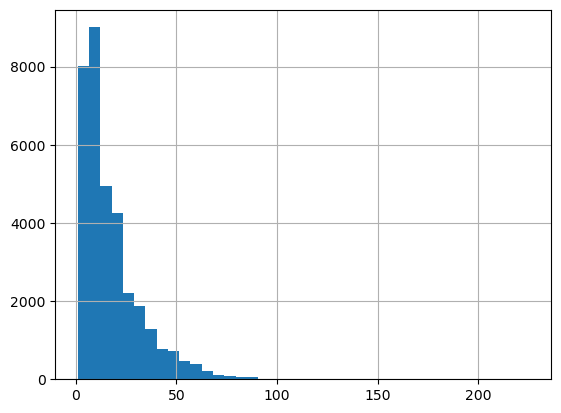

In [9]:
w=subtasks_week.groupby('user_id').week.agg(lambda x : len(set(x)))
print(w.describe())
w.hist(bins=40)

We also plot the ditributions of tasks, given a skill name and a number range. We see that most popular skills are about Number line skills, this is understandable since the majority of the games require a number mathematical number representations and involve beginner level math knowledge about numbers.
The trained model on Number line looks promising, (as we'll see in the evaluation part)


<Axes: xlabel='skill_name,number_range'>

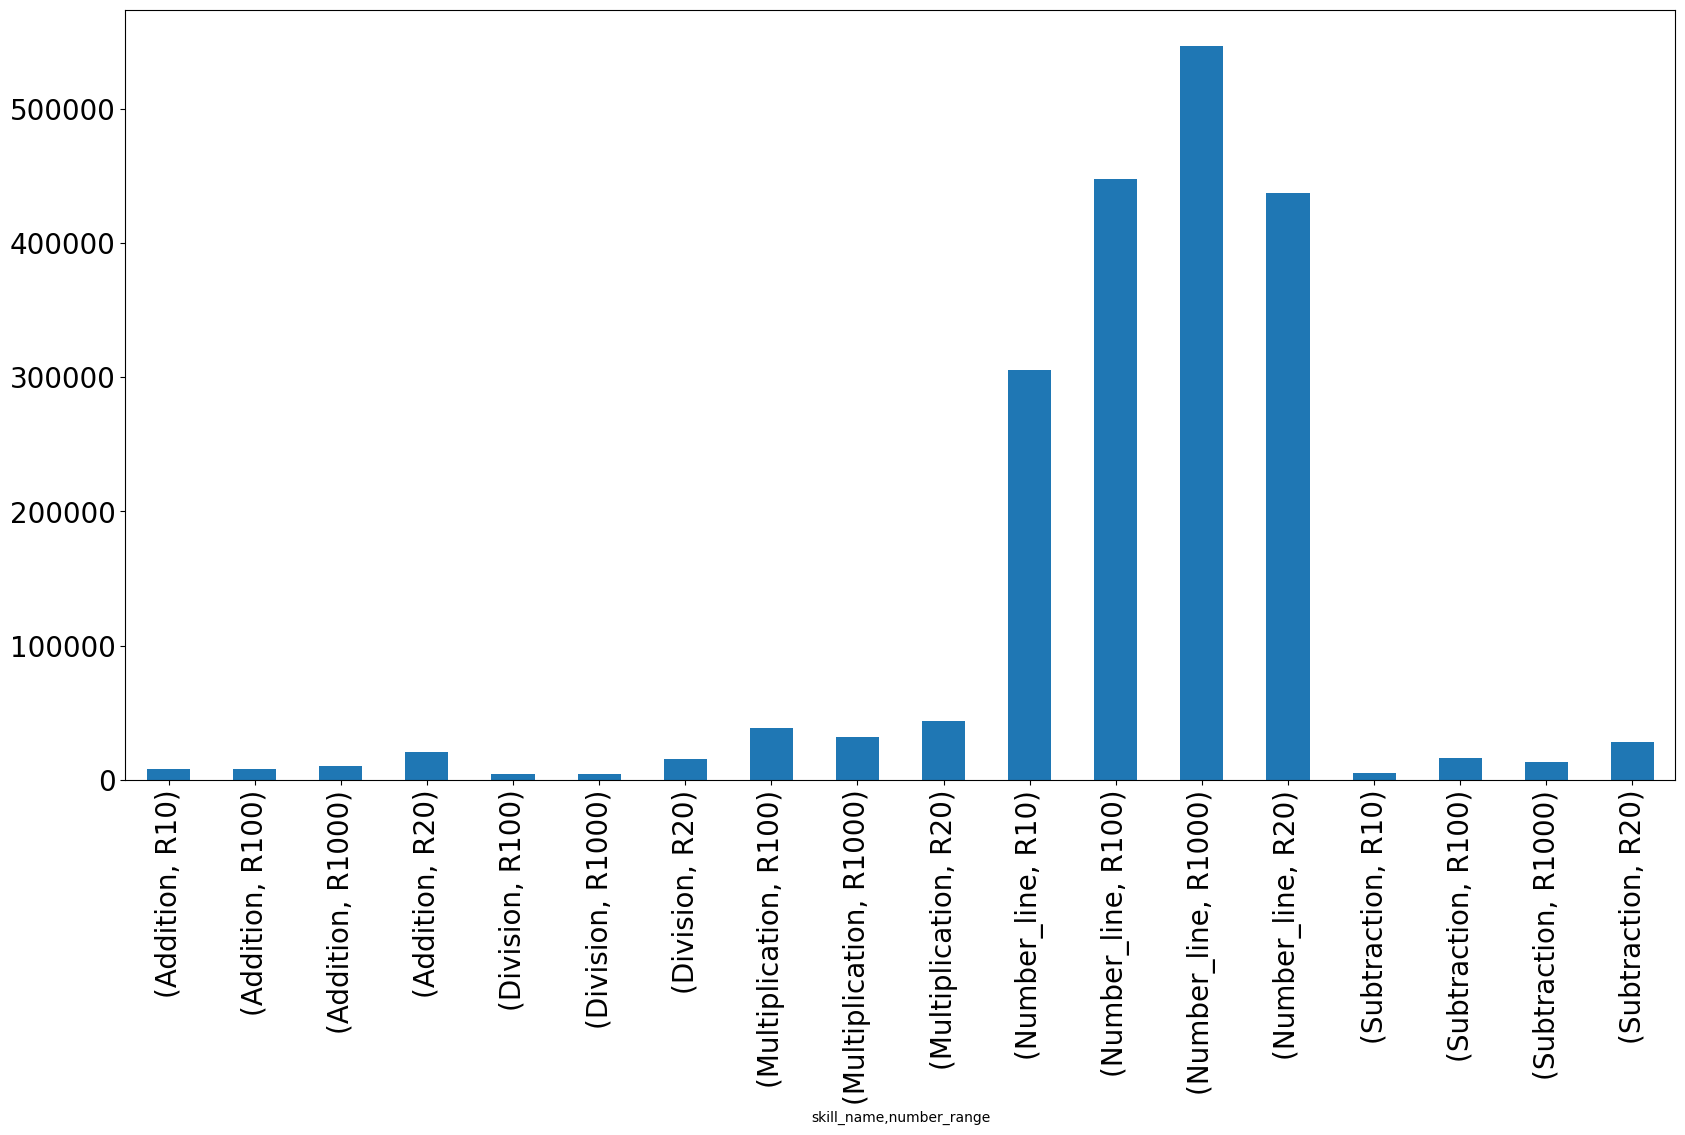

In [223]:
# Group df_subtasks by skill and number_range
df_subtasks_grouped = df_subtasks.groupby(['skill_name', 'number_range'])

# count frequency of each skill and number_range of df_subtasks_grouped
df_subtasks_grouped_count = df_subtasks_grouped.count()

# plot df_subtasks_grouped_count as bar plot keep only user_id column
df_subtasks_grouped_count['user_id'].plot(kind='bar', figsize=(20, 10), fontsize=20)

We save our 19 models for later usage/predictions

In [42]:
# Read all models from models/fit_1
# For every model in models/fit_1 print the params()
import os

seed = 0
for model in os.listdir(r'models/all_data/fit_5'):
    model_path =  ( os.getcwd() + "/models/all_data/fit_5/" + model).replace('/', '\\')
    pp.pprint(model)
    model = Model(seed=seed)
    model.load(model_path)
    print(model.params())
    print('*'*70)

'model_Addition_R10.pkl'
                           value
skill    param   class          
Addition prior   default 0.88775
         learns  10014   1.00000
                 10019   1.00000
                 10021   1.00000
                 10042   1.00000
...                          ...
         forgets 9917    0.00000
                 9940    0.00000
                 9954    0.00000
                 9969    0.00000
                 9977    0.00000

[12029 rows x 1 columns]
**********************************************************************
'model_Addition_R100.pkl'
                           value
skill    param   class          
Addition prior   default 0.76965
         learns  10019   1.00000
                 10047   1.00000
                 10096   1.00000
                 10161   1.00000
...                          ...
         forgets 9942    0.00000
                 9944    0.00000
                 9965    0.33334
                 9966    0.00000
                 9971    0.

## Task 3: Model Evaluation
The  previously saved models encapsulate all the needed informations for knowledge tracing of every users, learing probability, prior, etc

In [ ]:
# Generate cross pairs of skill_names and num_range_names
skill_num_range_pairs = [(skill, num_range) for skill in skill_names for num_range in num_range_names]
aucs = {skill : [] for skill in skill_names}
rmses = {skill : [] for skill in skill_names}

# Run models
for skill, num_range in skill_num_range_pairs[::-1]:
    print(skill, num_range)
    df_skill = subtasks_bkt[(subtasks_bkt['skill_name'] == skill) & (subtasks_bkt['number_range'] == num_range)]

    if df_skill.empty:
        continue

    val = round(len(df_skill)*0.8)
    x_train,x_test = df_skill[:val],df_skill[val:]
    defaults = {'assistment_id':'event_id','template_id':'skill_id', 'order_id':'subtask_id'}
    model = Model(seed=seed, num_fits=num_fits,defaults=defaults)
    model.fit(data=x_train, skills=skill, forgets=True, multilearn='skill_id')
    pp.pprint(model.params)
    auc=model.evaluate(data=x_test, metric='auc')
    aucs[skill].append(auc)
    rmse=model.evaluate(data=x_test, metric='rmse')
    rmses[skill].append(rmse)
    pp.pprint(f'auc: {auc}, rmse: {rmse}')
    model.save(f'models/split_data/skill_id/fit_{num_fits}/model_{skill}_{num_range}.pkl')
    
    
    print("*"*70)
    
    


Multiplication R1000
<bound method Model.params of Model(parallel=True, num_fits=5, seed=0, defaults={'assistment_id': 'event_id', 'template_id': 'skill_id', 'order_id': 'subtask_id', 'multilearn': 'skill_id', 'skill_name': 'skill_name', 'correct': 'correct', 'user_id': 'user_id', 'multiprior': 'correct', 'folds': 'user_id'})>
0.8124849733633094
**********************************************************************
Multiplication R100
<bound method Model.params of Model(parallel=True, num_fits=5, seed=0, defaults={'assistment_id': 'event_id', 'template_id': 'skill_id', 'order_id': 'subtask_id', 'multilearn': 'skill_id', 'skill_name': 'skill_name', 'correct': 'correct', 'user_id': 'user_id', 'multiprior': 'correct', 'folds': 'user_id'})>
0.758902012500469
**********************************************************************
Multiplication R20
<bound method Model.params of Model(parallel=True, num_fits=5, seed=0, defaults={'assistment_id': 'event_id', 'template_id': 'skill_id', 'order_i

KeyboardInterrupt: 

In [47]:
# Generate cross pairs of skill_names and num_range_names
skill_num_range_pairs = [(skill, num_range) for skill in skill_names for num_range in num_range_names]
aucs2 = {skill : [] for skill in skill_names}
rmses2 = {skill : [] for skill in skill_names}
# Run models
for skill, num_range in skill_num_range_pairs[::-1]:
    print(skill, num_range)
    df_skill = subtasks_week[(subtasks_week['skill_name'] == skill) & (subtasks_week['number_range'] == num_range)]
    

    #only keep users with at least 100 subtasks in this category
    s=df_skill.groupby(['user_id']).size()>=100 
    df_skill=df_skill[df_skill.user_id.isin(s[s].index)]

    if df_skill.empty:
        continue

    print('concerned users : ',df_skill['user_id'].unique())
    x_train = df_skill.groupby(['user_id']).apply(lambda x: x.head(round(0.8*len(x)))).reset_index(drop=True)
    x_test  = df_skill.groupby(['user_id']).apply(lambda x: x.tail(round(0.2*len(x)))).reset_index(drop=True)
    defaults = {'assistment_id':'event_id','template_id':'skill_id', 'order_id':'subtask_id'}
    model = Model(seed=seed, num_fits=num_fits,defaults=defaults)
    model.fit(data=x_train, skills=skill, forgets=True, multilearn='user_id',defaults=defaults)
    pp.pprint(model.params)
    auc=model.evaluate(data=x_test, metric='auc')
    aucs2[skill].append(auc)
    rmse=model.evaluate(data=x_test, metric='rmse')
    rmses2[skill].append(rmse)
    pp.pprint(f'auc: {auc}, rmse: {rmse}')
    
    
    model.save(f'models/split_data/users/100fit_{num_fits}/model_{skill}_{num_range}.pkl')
    
    
    print("*"*70)
    
    


Multiplication R1000
Multiplication R100
concerned users :  [19414 51274]
<bound method Model.params of Model(parallel=True, num_fits=5, seed=0, defaults={'assistment_id': 'event_id', 'template_id': 'skill_id', 'order_id': 'subtask_id', 'multilearn': 'user_id', 'skill_name': 'skill_name', 'correct': 'correct', 'user_id': 'user_id', 'multiprior': 'correct', 'folds': 'user_id'})>
'auc: 0.4073529411764706, rmse: 0.49384318372117614'
**********************************************************************
Multiplication R20
Multiplication R10
Division R1000
Division R100
Division R20
Division R10
Subtraction R1000
Subtraction R100
Subtraction R20
Subtraction R10
Addition R1000
Addition R100
Addition R20
Addition R10
Number_line R1000
concerned users :  [    2    88   208 ... 64397 64639 64798]


In [ ]:
# Generate cross pairs of skill_names and num_range_names
skill_num_range_pairs = [(skill, num_range) for skill in skill_names for num_range in num_range_names]
aucs3 = {skill : [] for skill in skill_names}
rmses3 = {skill : [] for skill in skill_names}
# Run models
for skill, num_range in skill_num_range_pairs[::-1]:
    print(skill, num_range)
    df_skill = subtasks_week[(subtasks_week['skill_name'] == skill) & (subtasks_week['number_range'] == num_range)]
    

    #only keep users with at least 50 subtasks in this category
    s=df_skill.groupby(['user_id']).size()>=50 
    df_skill=df_skill[df_skill.user_id.isin(s[s].index)]

    if df_skill.empty:
        continue

    print('concerned users : ',df_skill['user_id'].unique())
    x_train = df_skill.groupby(['user_id']).apply(lambda x: x.head(round(0.8*len(x)))).reset_index(drop=True)
    x_test  = df_skill.groupby(['user_id']).apply(lambda x: x.tail(round(0.2*len(x)))).reset_index(drop=True)
    defaults = {'assistment_id':'event_id','template_id':'skill_id', 'order_id':'subtask_id'}
    model = Model(seed=seed, num_fits=num_fits,defaults=defaults)
    model.fit(data=x_train, skills=skill, forgets=True, multilearn='user_id',defaults=defaults)
    pp.pprint(model.params)
    auc=model.evaluate(data=x_test, metric='auc')
    aucs3[skill].append(auc)
    rmse=model.evaluate(data=x_test, metric='rmse')
    rmses3[skill].append(rmse)
    pp.pprint(f'auc: {auc}, rmse: {rmse}')
    
    
    model.save(f'models/split_data/users/50fit_{num_fits}/model_{skill}_{num_range}.pkl')
    
    
    print("*"*70)
    
    


### In the following section we build a dataframe to evaluate all the previously fit models, using a train_test split method
Every model corresponds to a specefic skill within a difficulty range.

In [46]:
subtasks_bkt

,skill_id,user_id,event_id,subtask_id,skill_name,number_range,correct,prior_success
0,1,2,1,0,Number_line,R10,0,0
1,3,2,3,1,Number_line,R10,1,0
2,18,2,4,2,Number_line,R10,1,1
3,19,2,5,3,Number_line,R10,1,2
4,54,2,6,4,Addition,R20,1,0
...,...,...,...,...,...,...,...,...
1986192,18,64996,2399231,1986192,Number_line,R10,1,0
1986193,49,64996,2399232,1986193,Number_line,R20,1,0
1986194,62,64996,2399233,1986194,Subtraction,R20,1,0
1986195,43,64996,2399234,1986195,Number_line,R20,1,1


In [58]:
def create_iterator(data):
    '''
    Create an iterator to split interactions in data in 10 folds, with the same student not appearing in two diverse folds.
    :param data:        Dataframe with student's interactions.
    :return:            An iterator.
    '''
    
    # Both passing a matrix with the raw data or just an array of indexes works
    X = np.arange(len(data.index)) 
    # Groups of interactions are identified by the user id (we do not want the same user appearing in two folds)
    groups = data['user_id'].values 
    return model_selection.GroupKFold(n_splits=10).split(X, groups=groups)

In [62]:
def check_iterator(data):
    tested_user_ids = set()
    for iteration, (train_index, test_index) in enumerate(create_iterator(data)):
        user_ids = data['user_id'].unique()
        train_user_ids = data.iloc[train_index]['user_id'].unique()
        test_user_ids = data.iloc[test_index]['user_id'].unique()
        print('Iteration:', iteration)
        print('Intersection between train and test user ids:', set(train_user_ids) & set(test_user_ids))
        print('All user ids in train and test user union:', len(set(train_user_ids).union(set(test_user_ids))) == len(user_ids))
        print('User ids tested more than once:', set(tested_user_ids) & set(test_user_ids))
        tested_user_ids = tested_user_ids.union(set(test_user_ids))
        print()
    return tested_user_ids
#Example test on Division R1000
data = subtasks_bkt[(subtasks_bkt['skill_name'] == 'Division') & (subtasks_bkt['number_range'] == 'R1000')]
tested_user_ids=check_iterator(data,)
print(len(tested_user_ids))
len(tested_user_ids) == len(data.user_id.unique())

Iteration: 0
Intersection between train and test user ids: set()
All user ids in train and test user union: True
User ids tested more than once: set()

Iteration: 1
Intersection between train and test user ids: set()
All user ids in train and test user union: True
User ids tested more than once: set()

Iteration: 2
Intersection between train and test user ids: set()
All user ids in train and test user union: True
User ids tested more than once: set()

Iteration: 3
Intersection between train and test user ids: set()
All user ids in train and test user union: True
User ids tested more than once: set()

Iteration: 4
Intersection between train and test user ids: set()
All user ids in train and test user union: True
User ids tested more than once: set()

Iteration: 5
Intersection between train and test user ids: set()
All user ids in train and test user union: True
User ids tested more than once: set()

Iteration: 6
Intersection between train and test user ids: set()
All user ids in train a

True

Evaluation on test data using skill_id multilearn

In [87]:
def evaluate_bkt(data, seed=0, num_fits=5) :
    rmse_bkt, auc_bkt = [], []
    for iteration, (train_index, test_index) in enumerate(create_iterator(data)):
        # Split data in training and test sets
        X_train, X_test = data.iloc[train_index], data.iloc[test_index]
        print(len(X_train), len(X_test))
        # Initialize and fit the model
        model = Model(seed=seed, num_fits=num_fits)
        defaults = {'assistment_id':'event_id','template_id':'skill_id', 'order_id':'subtask_id','multiprior':'prior_success','folds': 'skill_id'}
        %time model.fit(data=X_train,multilearn='skill_id',forgets=True, defaults=defaults)
        # Compute RMSE
        train_rmse = model.evaluate(data=X_train, metric='rmse')
        test_rmse = model.evaluate(data=X_test, metric='rmse')
        rmse_bkt.append(test_rmse)
        # Compute AUC
        train_auc = model.evaluate(data=X_train, metric='auc')
        test_auc = model.evaluate(data=X_test, metric='auc')
        auc_bkt.append(test_auc)
        # Print progress
        print('Iteration:', iteration, 'RMSE', (train_rmse, test_rmse), 'AUC', (train_auc, test_auc))
        return model

evaluate_bkt(subtasks_bkt,num_fits=1)

3735 416
CPU times: total: 3.47 s
Wall time: 52.8 s
Iteration: 0 RMSE (0.4875647676455369, 0.4951732358687007) AUC (0.5837172405549697, 0.5656769348445866)
Model(parallel=True, num_fits=1, seed=0, defaults={'assistment_id': 'event_id', 'template_id': 'skill_id', 'order_id': 'subtask_id', 'multiprior': 'prior_success', 'folds': 'skill_id', 'multilearn': 'skill_id', 'skill_name': 'skill_name', 'correct': 'correct', 'user_id': 'user_id'})


value
skill    param   class          
Division prior   default 0.75296
         learns  240     0.05130
                 241     0.02597
                 242     0.00000
                 243     0.00231
                 244     0.00044
                 246     0.32642
                 247     0.42908
                 248     0.98528
                 249     0.70614
         guesses default 0.33045
         slips   default 0.28696
         forgets 240     0.09128
                 241     0.09301
                 242     0.24538
                 243     0.04247
                 244     0.44626
                 246     0.13637
                 247     0.20657
                 248     0.07126
                 249     0.08112

In [229]:
# Create mapping column for skill 
col_names = { "skill" : "skill_name"}
df_subtasks.rename(columns=col_names, inplace=True)
df_subtasks.head()

,event_id,user_id,mode,game_name,learning_time_ms,subtasks,number_range,start,end,skill_id,type,score,sub_types,skill_name,correct
subtask_id,,,,,,,,,,,,,,,
0,1,2,NORMAL,Subitizing,"13,094.00000","{'hasProperResult': True, 'range': 'R10', 'cor...",R10,2020-08-20T07:13:50.876Z,2020-08-20T07:14:30.108Z,1,task,0,ConciseSubitizingTaskDescription,Number_line,0
1,3,2,NORMAL,Conversion,"15,879.00000","{'answer': 6, 'range': 'R10', 'correct': True,...",R10,2020-08-21T07:02:20.112Z,2020-08-21T07:02:36.221Z,3,task,1,ConciseConversionTaskDescription,Number_line,1
2,4,2,NORMAL,Landing,"6,075.00000","{'range': 'R10', 'correct': True, 'lowerBound'...",R10,2020-08-24T07:02:59.855Z,2020-08-24T07:03:07.382Z,18,task,1,ConciseLandingTaskDescription,Number_line,1
3,5,2,NORMAL,Landing,"6,910.00000","{'range': 'R10', 'correct': True, 'lowerBound'...",R10,2020-08-26T06:47:21.504Z,2020-08-26T06:47:30.050Z,19,task,1,ConciseLandingTaskDescription,Number_line,1
4,6,2,NORMAL,Calculator,"7,507.00000","{'range': 'R20', 'answerMode': 'RESULT', 'corr...",R20,2020-08-26T07:20:58.766Z,2020-08-26T07:21:06.439Z,54,task,2,ConciseEquationTaskDescription,Addition,1


Train evaluation

In [230]:
from pandas.core.frame import DataFrame

def models_path(folder: str = 'models/fit_1', seed: int = 0) -> DataFrame:
     """Create a dataframe with the  skill name, number rannge and the pre-trained model as well

     Args:
         folder (str, optional): folder were all the fit models are saved. Defaults to 'models/fit_1'.
         seed (int, optional): seed that was used to fit the models. Defaults to 0.

     Returns:
         DataFrame: _description_
     """
     paths = [os.path.join(folder, file) for file in os.listdir(folder)]
     ranges = [path.removesuffix('.pkl').split('_')[-1] for path in paths]
     skills = [path.removesuffix('.pkl').split('_')[-2] for path in paths]
     
     # map skills if is "line" to "Number_line"
     skills = ['Number_line' if skill == 'line' else skill for skill in skills]
     
     models=[]
     for model_path in paths:
          model = Model(seed=seed)
          model.load(model_path)
          models.append(model)
     
     
     # Create dataframe  indexed with ranges and skill with column path 
     df_paths = pd.DataFrame({'model': models}, index=[skills, ranges])
     
     #Rename index of value "line" to "Number_line"
     df_paths.index.names = ['skill_name', 'number_range']

     return df_paths

In [233]:
models_path(folder='models/skill_id')

model
skill_name number_range                                                   
id\model   R10           Model(parallel=True, num_fits=5, seed=0, defau...
           R100          Model(parallel=True, num_fits=5, seed=0, defau...
           R1000         Model(parallel=True, num_fits=5, seed=0, defau...
           R20           Model(parallel=True, num_fits=5, seed=0, defau...

In [231]:
models_path(folder='models/fit_5')

model
skill_name     number_range                                                   
Addition       R10           Model(parallel=True, num_fits=5, seed=0, defau...
               R100          Model(parallel=True, num_fits=5, seed=0, defau...
               R1000         Model(parallel=True, num_fits=5, seed=0, defau...
               R20           Model(parallel=True, num_fits=5, seed=0, defau...
Division       R100          Model(parallel=True, num_fits=5, seed=0, defau...
               R1000         Model(parallel=True, num_fits=5, seed=0, defau...
               R20           Model(parallel=True, num_fits=5, seed=0, defau...
Multiplication R100          Model(parallel=True, num_fits=5, seed=0, defau...
               R1000         Model(parallel=True, num_fits=5, seed=0, defau...
               R20           Model(parallel=True, num_fits=5, seed=0, defau...
Number_line    R10           Model(parallel=True, num_fits=5, seed=0, defau...
               R100          Model(parallel=True, num_fits=5, seed=0, defau...
               R1000         Model(parallel=True, num_fits=5, seed=0, defau...
               R20           Model(parallel=True, num_fits=5, seed=0, defau...
Subtraction    R10           Model(parallel=True, num_fits=5, seed=0, defau...
               R100          Model(parallel=True, num_fits=5, seed=0, defau...
               R1000         Model(parallel=True, num_fits=5, seed=0, defau...
               R20           Model(parallel=True, num_fits=5, seed=0, defau...

In [234]:
models = {}
df_model_skill = models_path(folder='models/fit_5')

#Snapshot of the models
for name, model in df_model_skill.head(2).model.items():
    print("-".join(name))
    print(model.params())
    print()


Addition-R10
                           value
skill    param   class          
Addition prior   default 0.88775
         learns  10014   1.00000
                 10019   1.00000
                 10021   1.00000
                 10042   1.00000
...                          ...
         forgets 9917    0.00000
                 9940    0.00000
                 9954    0.00000
                 9969    0.00000
                 9977    0.00000

[12029 rows x 1 columns]

Addition-R100
                           value
skill    param   class          
Addition prior   default 0.76965
         learns  10019   1.00000
                 10047   1.00000
                 10096   1.00000
                 10161   1.00000
...                          ...
         forgets 9942    0.00000
                 9944    0.00000
                 9965    0.33334
                 9966    0.00000
                 9971    0.00000

[8729 rows x 1 columns]



In [235]:
def get_data(df_subtasks, skill, num_range):
    """Gets user data for a given skill and number range.

    Args:
        df_subtasks (DataFrame): Dataframe with subtasks data [skill_name, number_range, skill_id, user_id, correct]
        skill (str): Skill name ['Addition', 'Subtraction', 'Multiplication', 'Division', 'Number_line']
        num_range (str): Number range ['R10', 'R20', 'R100', 'R1000']

    Returns:
        DataFrame: User data for a particular skill and number range
    """
    df = df_subtasks.loc[(df_subtasks['skill_name'] == skill) & (df_subtasks['number_range'] == num_range)]
    return df

We compute evaluate the model by computing the auc and rmse metrics <br>
Takes roughly 20 mins

In [236]:
# for evrey row in df_model_skill compute auc and rmse then add to df_model_skill
for skill, num_range in df_model_skill.index:
    model = df_model_skill.loc[(skill, num_range), 'model']
    data = get_data(df_subtasks, skill, num_range)
    auc = model.evaluate(data=data, metric='auc') 
    rmse = model.evaluate(data=data, metric='rmse')
    df_model_skill.loc[(skill, num_range), 'auc'] = auc
    df_model_skill.loc[(skill, num_range), 'rmse'] = rmse
    print(f'{skill=} {num_range=} {auc=} {rmse=}')

skill='Addition' num_range='R10' auc=0.7376440226623837 rmse=0.29316947769896684
skill='Addition' num_range='R100' auc=0.7929902325260307 rmse=0.3737673613632123
skill='Addition' num_range='R1000' auc=0.8139454803021912 rmse=0.379403972957961
skill='Addition' num_range='R20' auc=0.8233486860457484 rmse=0.3429682497975902
skill='Division' num_range='R100' auc=0.8403553264237082 rmse=0.351078317109744
skill='Division' num_range='R1000' auc=0.7901821216120306 rmse=0.4181431673076001
skill='Division' num_range='R20' auc=0.8449417143446134 rmse=0.3561797198257594
skill='Multiplication' num_range='R100' auc=0.9366812459750867 rmse=0.18577766138181062
skill='Multiplication' num_range='R1000' auc=0.943155476091771 rmse=0.18270696547808798
skill='Multiplication' num_range='R20' auc=0.8548028602822157 rmse=0.29777791131710457
skill='Number_line' num_range='R10' auc=0.8117116958986403 rmse=0.39247063614336036
skill='Number_line' num_range='R100' auc=0.7447888129812706 rmse=0.4007453377548083
skil

In [237]:
# Save df_model_skill to pkl file
df_model_skill.to_pickle('models/df_model_skill.pkl')

In [235]:
df_model_skill = pd.read_pickle('models/df_model_skill.pkl')

Finally the dataframe

In [236]:
df_model_skill

model  \
skill_name     number_range                                                      
Addition       R10           Model(parallel=True, num_fits=5, seed=0, defau...   
               R100          Model(parallel=True, num_fits=5, seed=0, defau...   
               R1000         Model(parallel=True, num_fits=5, seed=0, defau...   
               R20           Model(parallel=True, num_fits=5, seed=0, defau...   
Division       R100          Model(parallel=True, num_fits=5, seed=0, defau...   
               R1000         Model(parallel=True, num_fits=5, seed=0, defau...   
               R20           Model(parallel=True, num_fits=5, seed=0, defau...   
Multiplication R100          Model(parallel=True, num_fits=5, seed=0, defau...   
               R1000         Model(parallel=True, num_fits=5, seed=0, defau...   
               R20           Model(parallel=True, num_fits=5, seed=0, defau...   
Number_line    R10           Model(parallel=True, num_fits=5, seed=0, defau...   
               R100          Model(parallel=True, num_fits=5, seed=0, defau...   
               R1000         Model(parallel=True, num_fits=5, seed=0, defau...   
               R20           Model(parallel=True, num_fits=5, seed=0, defau...   
Subtraction    R10           Model(parallel=True, num_fits=5, seed=0, defau...   
               R100          Model(parallel=True, num_fits=5, seed=0, defau...   
               R1000         Model(parallel=True, num_fits=5, seed=0, defau...   
               R20           Model(parallel=True, num_fits=5, seed=0, defau...   

                                auc    rmse  
skill_name     number_range                  
Addition       R10          0.73764 0.29317  
               R100         0.79299 0.37377  
               R1000        0.81395 0.37940  
               R20          0.82335 0.34297  
Division       R100         0.84036 0.35108  
               R1000        0.79018 0.41814  
               R20          0.84494 0.35618  
Multiplication R100         0.93668 0.18578  
               R1000        0.94316 0.18271  
               R20          0.85480 0.29778  
Number_line    R10          0.81171 0.39247  
               R100         0.74479 0.40075  
               R1000        0.73561 0.33865  
               R20          0.75118 0.37435  
Subtraction    R10          0.71306 0.35611  
               R100         0.80025 0.39880  
               R1000        0.80652 0.40069  
               R20          0.81558 0.37002

In [240]:
for s in skill_names :
    print(s)
    print(df_model_skill.loc[(s)].mean())
    print('*'*10)

Number_line
auc    0.76082
rmse   0.37655
dtype: float64
**********
Addition
auc    0.79198
rmse   0.34733
dtype: float64
**********
Subtraction
auc    0.78385
rmse   0.38141
dtype: float64
**********
Division
auc    0.82516
rmse   0.37513
dtype: float64
**********
Multiplication
auc    0.91155
rmse   0.22209
dtype: float64
**********


C:\Users\Yassine\AppData\Local\Temp\ipykernel_8012\1498378495.py:3: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(df_model_skill.loc[(s)].mean())
C:\Users\Yassine\AppData\Local\Temp\ipykernel_8012\1498378495.py:3: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(df_model_skill.loc[(s)].mean())
C:\Users\Yassine\AppData\Local\Temp\ipykernel_8012\1498378495.py:3: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_on

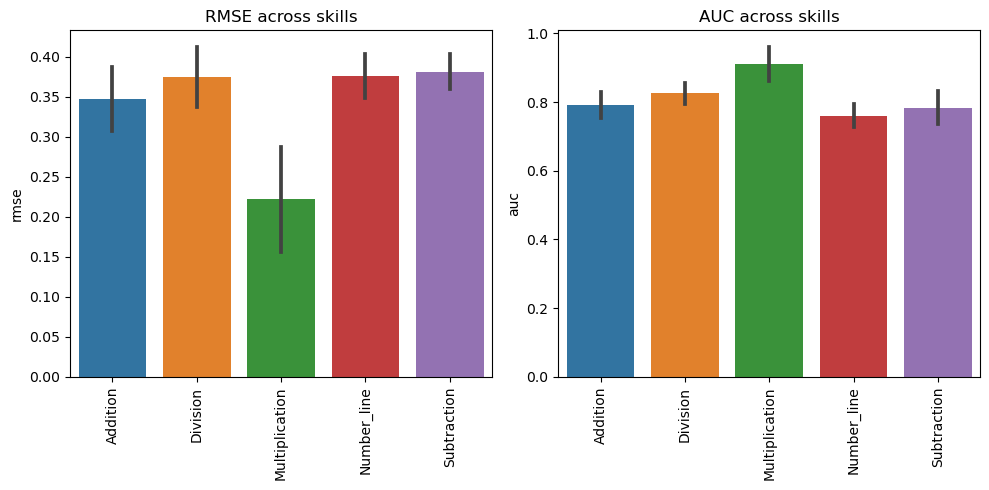

In [241]:
def plots(df_model_skill):
 
    # Two bar plots for RMSE: first one with std (mean RMSE over all skills), then one bar plot with a bar for each specific skill
    fig, axes = plt.subplots(1, 2, figsize=(10,5))
    
    # select index skill
    df_model_skill = df_model_skill.reset_index()
    df_model_skill.index = df_model_skill.skill_name
    
    skills = df_model_skill.index.to_list()
    
    sns.barplot(ax=axes[0],x=skills, y=df_model_skill.rmse, estimator=np.mean, ci='sd')
    axes[0].set_title('RMSE across skills')
    axes[0].set_xlabel('', rotation=90)


    sns.barplot(ax=axes[1] ,x=skills, y=df_model_skill.auc,estimator=np.mean, ci='sd')
    axes[1].set_title('AUC across skills')
    axes[1].set_xlabel('', rotation=90)
    
    # rotate labels of x axis
    for ax in axes:
        ax.tick_params(axis='x', rotation=90)
    
    fig.show()
    plt.tight_layout()
    
plots(df_model_skill)

### As shown in the above plot we get precision of ~65% (auc) and an accuracy of ~40% (rmse) per category

In [242]:
# Read data from pkl file
id_map = pd.read_pickle('data/id_map.pkl')

### We proceed to show some plots about predicting user skill response

In [243]:
def get_user_data(user_id, skill_id):
    return df_subtasks.loc[(df_subtasks['user_id'] == user_id) & (df_subtasks['skill_id'] == skill_id)]


def predict_user_performance(df_subtasks: DataFrame, user_id: int, skill_id: int):
    """Predict a user performance for a given skill_id using the pre-trained model

    Args:
        df_subtasks (DataFrame): dataframe of all subtasks  
        user_id (int): user
        skill_id (int): specific skill

    Returns:
        _type_: _description_
    """
    # Get key from value skill_id in skill_ids_map
    skill = id_map.loc[(skill_id), 'skill_name']
    label = id_map.loc[(skill_id), 'label']
    
    number_range = id_map.loc[(skill_id), 'number_range']
    # Get user data for skill_id
    df_user = get_user_data(user_id, skill_id)
    
    if df_user.empty:
        print(f'User {user_id} has no data for skill {skill_id}')
        return None, None, None
    
    # Get model for skill_id
    model = df_model_skill.loc[(skill, number_range), 'model']
    # Get predictions for user_id
    predictions = np.array(model.predict(data=df_user)['correct_predictions'])
    true_values = np.array(df_user['correct'])
    
    # Compute mse, auc and rmse
    mse = ((predictions - true_values) ** 2).mean()
    auc = model.evaluate(data=df_user, metric='auc')
    rmse = model.evaluate(data=df_user, metric='rmse')

    
    print(f'{skill=} {skill_id=} {mse=}')
    
    # Plot predictions and true values
    plt.figure(figsize=(10, 5))
    plt.plot(predictions, label='predictions')
    plt.plot(true_values, label='true values')

    plt.title(f'User {user_id} | Task: {label}')
    plt.legend()
    plt.show()
    
    return mse, predictions, true_values, auc, rmse


def predict_group_of_users_perormance(user_ids, df_subtasks, skill_id):
    
    # columns mse, predictions, true_values of empty df
    df = pd.DataFrame(columns=['mse', 'rmse', 'auc', 'predictions', 'true_values'])
    
    for user_id in user_ids:
        mse, predictions, true_values, auc, rmse  = predict_user_performance(df_subtasks, user_id, skill_id)
        # Insert row with index user_id to df and values mse, predictions, true_values
        df.loc[user_id] = [mse, rmse, auc, predictions, true_values]
        
    return df

We predict the performence of a user win a more specific skill (skill deeper than the general category)

skill='Number_line' skill_id=178 mse=0.05814216373489992


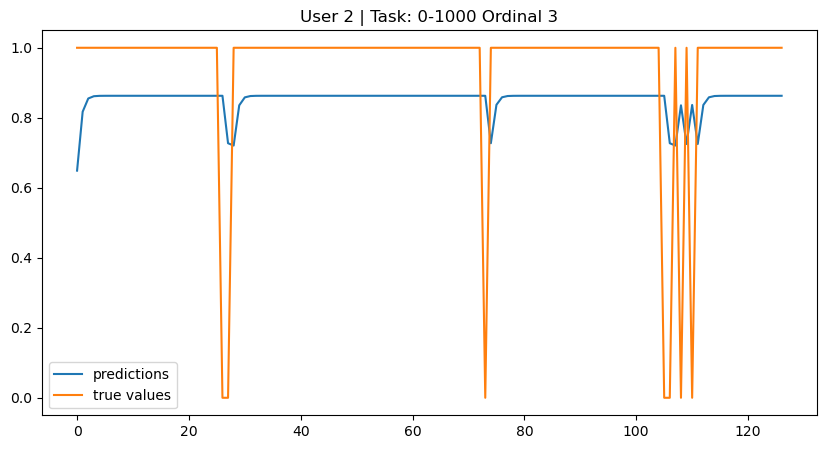

In [244]:
#Example of usage for user_id=2 and skill_id=111
mse, predictions, true_values, auc, rmse = predict_user_performance(df_subtasks, user_id=2, skill_id=178)

We analyze now the leaning behavior most popular skills among users

In [245]:
user_skill = df_subtasks.groupby(['user_id'])['skill_id'].agg(pd.Series.mode)
freqs = df_subtasks.groupby(['user_id'])['skill_id'].count()
df_user_skill = pd.DataFrame({'skill_id':user_skill.values, 'frequency':freqs.values}, index=user_skill.index)

# Order by frequency
df_user_skill = df_user_skill.sort_values(by=['frequency'], ascending=False)
df_user_skill.head()

,skill_id,frequency
user_id,,
18091,107,1401
54637,178,1127
1657,178,970
22376,178,888
42852,178,873


skill='Number_line' skill_id=107 mse=0.08296393300850455


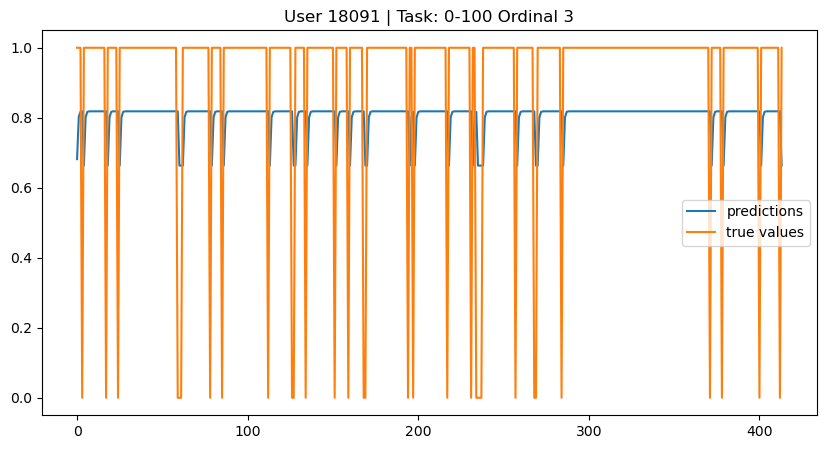

skill='Number_line' skill_id=178 mse=0.010893229665844672


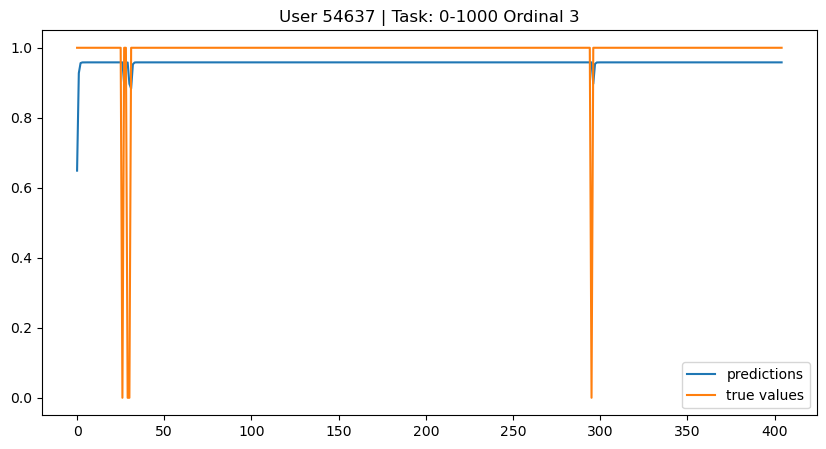

skill='Number_line' skill_id=178 mse=0.03581819334644459


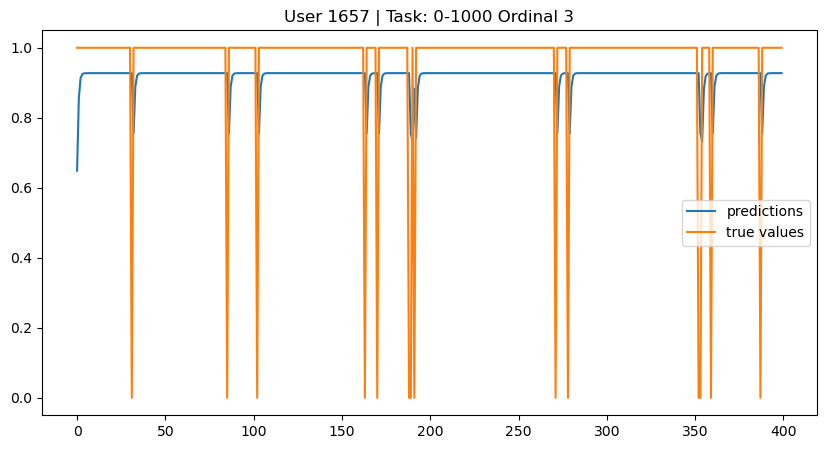

skill='Number_line' skill_id=178 mse=0.11108135653271613


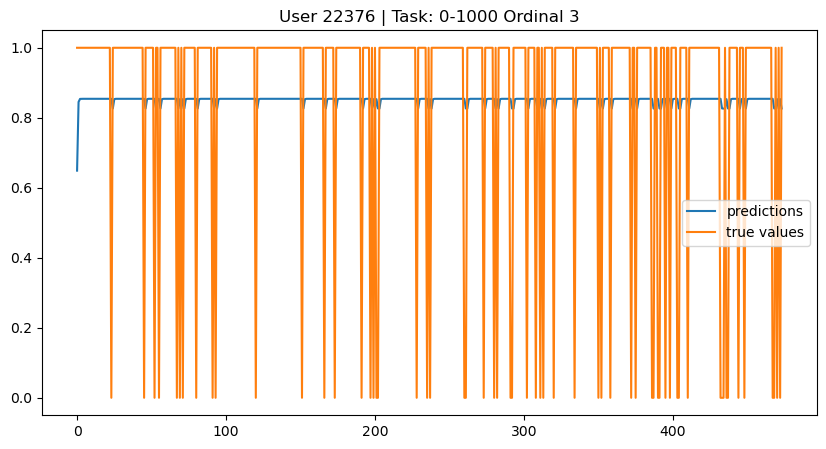

skill='Number_line' skill_id=178 mse=0.11356105236646892


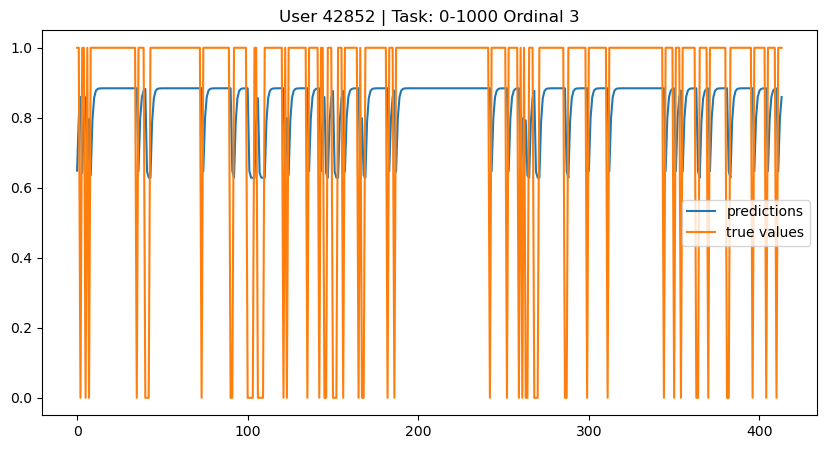

skill='Number_line' skill_id=178 mse=0.11356105237865993


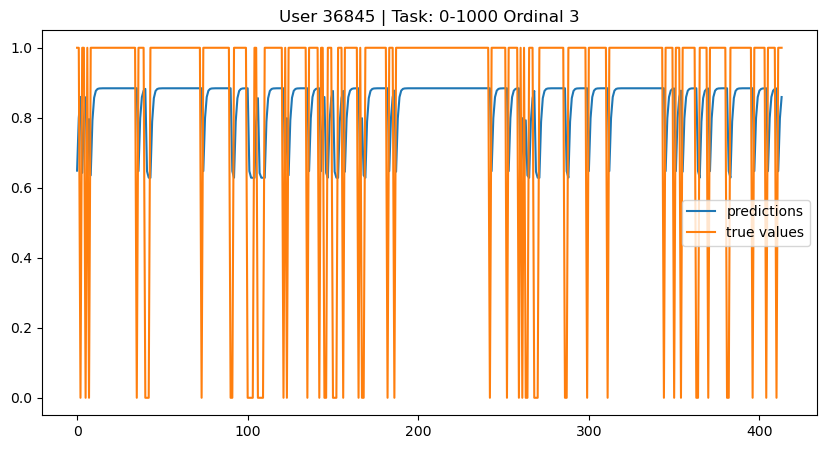

In [246]:
# Predictions for users with most data and their most frequent skill
for user in df_user_skill.head(6).index:
    skill_id = df_user_skill.loc[user, 'skill_id']
    predict_user_performance(df_subtasks, user, skill_id)

It looks like the most popular skill is Ordinal 3 eith diffictly range 1000, our Number_line R1000 model predicts that most learners achieve mastering of this basic skill with high probability of having learning that skill  

## Task 4: Team Reflection
Please describe the contributions of each team member to Milestone 4. Reflect on how you worked as team: what went well, what can be improved for the next milestone?

Everyone has his good share of the project, the taks subdivision was highly effective and everyone worked on his part. We didn't communicated a lot which lead to some misunderstanding and bit of wasted time. For next milestone we plan to use the Board feature that github provides to keep track of everyone's progress and list issues for everyone to discuss.
Thank you! 
